# Paul Rongieras

# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

In [1]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Sectioon 4.

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU.

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
    print ("MPS (MacBook) device found.")
    #print('Number of MPS cards: ', torch.mps.device_count())
    #print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x)
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   x = torch.ones(1, device=device)
   print(x)
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.9.0+cu126
tensor([1.], device='cuda:0')
CUDA device found.
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.83 GB. Free GPU memory 15.70 GB


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model.

In [3]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0
num_epochs = 5
batch_size=256 # adapted to the Google Colab GPU
learning_rate=0.001
loss_model=nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [4]:
mnist_train = Data.MNIST(root='data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

train_loader  = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = Data.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = DataLoader(dataset=mnist_test,
                                          batch_size=10000,
                                          shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.75MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.9MB/s]


We analyse the data to check the number of samples and their size.

In [5]:
# Print infomration
print("There are ", len (mnist_train), "training images and ", len(mnist_test), "test images")
image_size=list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]


There are  60000 training images and  10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article.

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model. Since we will use the Cross Entropy loss of Pytorch, the model should output the unnormalized logits for each class.

In [6]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

**Question**: Create one of the model proposed in the article.

**Answer**: we recreated the 2 layer 100-100-10 non-convolutional neural network used in the article.

In [7]:
input_size = len(torch.flatten(mnist_train[0][0]))
hidden_sizes = [100, 100]
output_size = 10

# Model
model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print(model)

FullyConnectedNet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [ ]:
def training(model, train_loader, optimizer, num_epochs, loss_model):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

And we evaluate it.

In [ ]:
def evaluation(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)

      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()

  print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

In [ ]:
# Training loop
training(model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 0.4105
Epoch [1/5], Step [200/235], Loss: 0.2465
Epoch [2/5], Step [100/235], Loss: 0.2456
Epoch [2/5], Step [200/235], Loss: 0.1558
Epoch [3/5], Step [100/235], Loss: 0.1480
Epoch [3/5], Step [200/235], Loss: 0.2276
Epoch [4/5], Step [100/235], Loss: 0.0665
Epoch [4/5], Step [200/235], Loss: 0.1742
Epoch [5/5], Step [100/235], Loss: 0.0973
Epoch [5/5], Step [200/235], Loss: 0.1687


In [ ]:
evaluation(model, test_loader)

Accuracy of test images: 96.900000 %


**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model.

**Answer**: we obtain an accuracy of 96,90% with the initial model (and initial hyperparameters). We test if we can upgrade it.

First, we only change hyperparameters (and not the architecture). We use quadratic weight decay on the connection weights as in the article, and move the number of epochs to 10.

In [8]:
weight_decay = 0 # we don't change it as we code the decay manually
                 # (it changes at each layer)
num_epochs = 10
batch_size=256
learning_rate=0.001
loss_model=nn.CrossEntropyLoss()
lmbda = 0.01

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# We recreate the training loop, adding quadratic weight decay

def training2(model, train_loader, optimizer, num_epochs, loss_model):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Here, we code the quadratic weight decay
        reg_loss = 0
        for name, param in model.named_parameters():
            # We only penalize weights
            if 'weight' in name:
                # k is the number of units in the layer (output size)
                k = param.size(0)
                # lambda * sum(w^2) / k
                reg_loss += lmbda * torch.sum(param**2) / k

        total_loss = loss + reg_loss

        # Backward and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {total_loss.item():.4f}')

In [ ]:
training2(model, train_loader, optimizer, num_epochs, loss_model)

evaluation(model, test_loader)

Epoch [1/10], Step [100/235], Loss: 0.1447
Epoch [1/10], Step [200/235], Loss: 0.1471
Epoch [2/10], Step [100/235], Loss: 0.1023
Epoch [2/10], Step [200/235], Loss: 0.1267
Epoch [3/10], Step [100/235], Loss: 0.1129
Epoch [3/10], Step [200/235], Loss: 0.1145
Epoch [4/10], Step [100/235], Loss: 0.0959
Epoch [4/10], Step [200/235], Loss: 0.0869
Epoch [5/10], Step [100/235], Loss: 0.1237
Epoch [5/10], Step [200/235], Loss: 0.0950
Epoch [6/10], Step [100/235], Loss: 0.1335
Epoch [6/10], Step [200/235], Loss: 0.1198
Epoch [7/10], Step [100/235], Loss: 0.0954
Epoch [7/10], Step [200/235], Loss: 0.1111
Epoch [8/10], Step [100/235], Loss: 0.0784
Epoch [8/10], Step [200/235], Loss: 0.1053
Epoch [9/10], Step [100/235], Loss: 0.0842
Epoch [9/10], Step [200/235], Loss: 0.0855
Epoch [10/10], Step [100/235], Loss: 0.0938
Epoch [10/10], Step [200/235], Loss: 0.0788
Accuracy of test images: 97.640000 %


We observe better performances (97.64%). We try now to modify the architecture to see if we can upgrade the accuracy one more time, still using the quadratic weight decay. We simply add a hidden layer of size 100.

In [ ]:
class FullyConnectedNet2(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

input_size3 = len(torch.flatten(mnist_train[0][0]))
hidden_sizes3 = [100, 100, 100]
output_size3 = 10

# Model
model3 = FullyConnectedNet2(input_size3, hidden_sizes3, output_size3).to(device)
# Optimizer
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

In [ ]:
training2(model3, train_loader, optimizer3, num_epochs, loss_model)

evaluation(model3, test_loader)

Epoch [1/10], Step [100/235], Loss: 0.3513
Epoch [1/10], Step [200/235], Loss: 0.2940
Epoch [2/10], Step [100/235], Loss: 0.1723
Epoch [2/10], Step [200/235], Loss: 0.2777
Epoch [3/10], Step [100/235], Loss: 0.2913
Epoch [3/10], Step [200/235], Loss: 0.1908
Epoch [4/10], Step [100/235], Loss: 0.1856
Epoch [4/10], Step [200/235], Loss: 0.1836
Epoch [5/10], Step [100/235], Loss: 0.1277
Epoch [5/10], Step [200/235], Loss: 0.1652
Epoch [6/10], Step [100/235], Loss: 0.1163
Epoch [6/10], Step [200/235], Loss: 0.1000
Epoch [7/10], Step [100/235], Loss: 0.0860
Epoch [7/10], Step [200/235], Loss: 0.1275
Epoch [8/10], Step [100/235], Loss: 0.1313
Epoch [8/10], Step [200/235], Loss: 0.1258
Epoch [9/10], Step [100/235], Loss: 0.0993
Epoch [9/10], Step [200/235], Loss: 0.1090
Epoch [10/10], Step [100/235], Loss: 0.0740
Epoch [10/10], Step [200/235], Loss: 0.0678
Accuracy of test images: 97.370000 %


As it is worse (accuracy of 97.37%) and according to the Ockham's razor principle, we keep our second model (same architecture as the first one but with the use of quadratic weight decay) and its high accuracy (97.64%).

### 2nd Part
Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : R^m \rightarrow {1 . . . k}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : R^m × {1 . . . k} \rightarrow R^+$. For a given $x \in R^m$ image and target label $l \in {1 . . . k}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [ ]:
# Parameters adversarial example
index=666 # index test image to use

max_iter_search=300
initial_c = 0.000001  # Initial value of c
max_c = 0.01  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

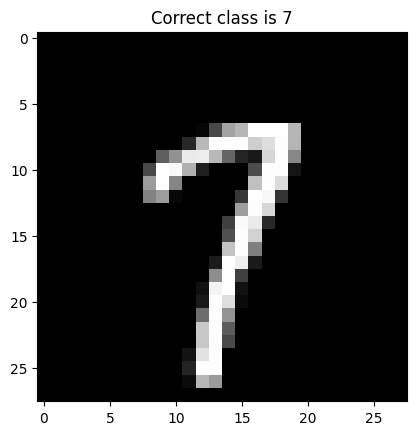

In [ ]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [9]:
def plot_results(X, r, Xr, Y, l, fail=True):


    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(X.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[0].set_title(f"Original Image. Correct class is {Y}",fontsize=22)

    im3=axes[2].imshow(r.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[2].set_title(f"Residual added",fontsize=22)

    if fail:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
        axes[1].set_title(f"Modified Image, FAILED to predict class {l.item()}",fontsize=22)
    else:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}",fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Intensity (0 to 1)')

    # Show the plots
    plt.show()

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

In [ ]:
testI=testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label=1 # manually chosen target class label different from true one
l = torch.tensor([label]).to(device)
l=l.to(device)
l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")

The true class is 7, the new class will be 1


Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 961.72509765625


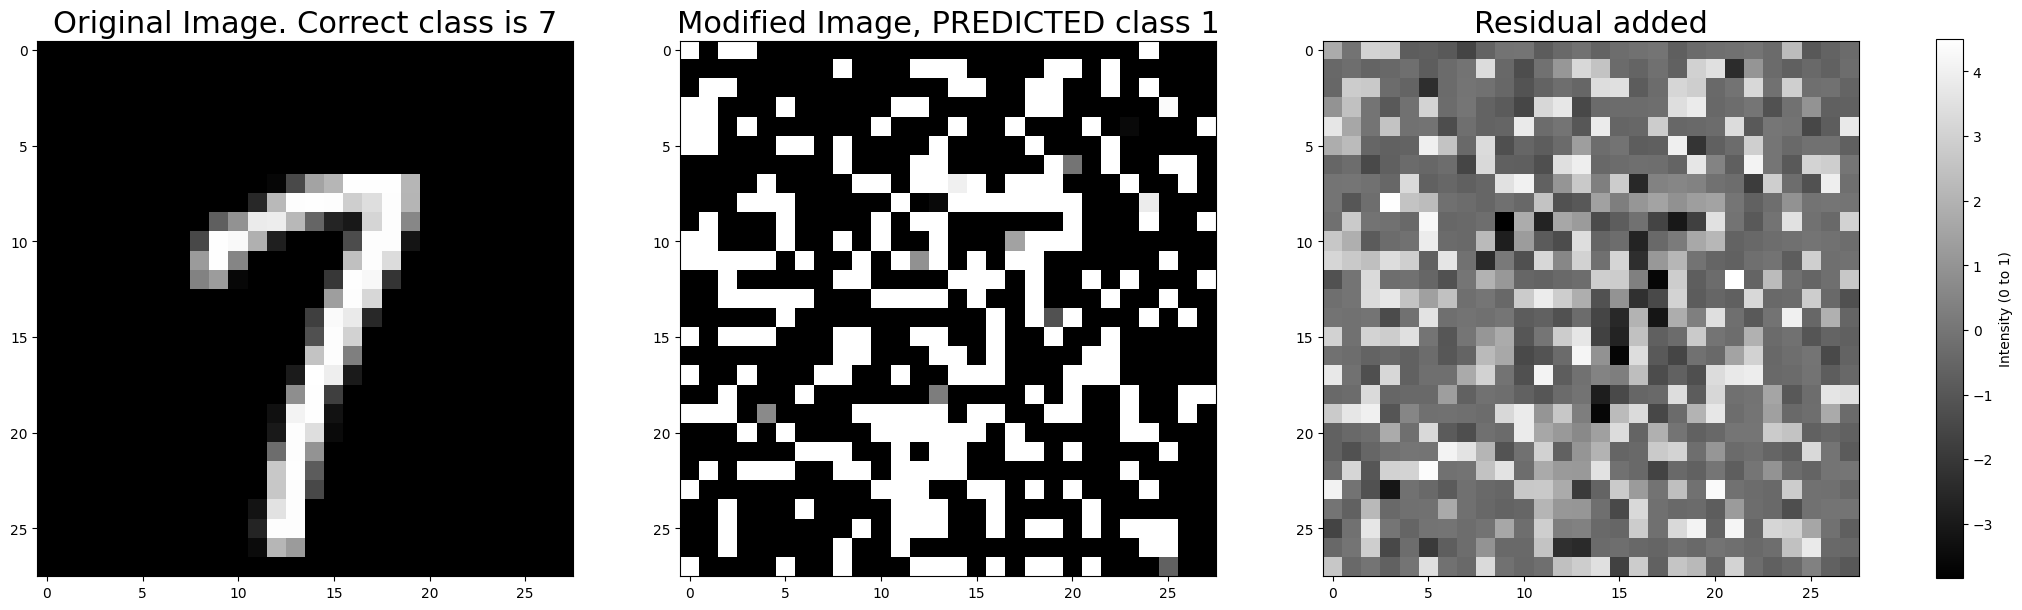

In [ ]:
# Define the loss function
loss_f = nn.CrossEntropyLoss()

def objective(c, r, x, l):
    x_r = torch.clamp(x+r, 0, 1)
    return c * torch.abs(r).sum() + loss_f(model(x_r), l) # we use L1 norm of r


# Line search to find the minimum c > 0
c = initial_c
iter=0
while (c <= max_c) and (iter <= max_iter_search):
    # Define the optimizer (Box-Constrained L-BFGS)
    optimizerLBFGS = optim.LBFGS([r],
                                 lr=lr_LBFGS,
                                 max_iter=max_iter_LBFGS,
                                 tolerance_grad=epsilon_LBFGS,
                                 tolerance_change=epsilon_LBFGS,
                                 line_search_fn='strong_wolfe'
                                 )

    def closure():
      optimizerLBFGS.zero_grad()
      loss = objective(c, r, testI, l)
      loss.backward()
      return loss

    # Perform optimization
    optimizerLBFGS.step(closure)


    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        iter=iter+1
        break
    else:
        iter=iter+1

    # If not satisfied, increase c
    c *= mult_c # Adjust step size for line search
    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=True)

else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    #print(f"Perturbation r: {r}")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    plot_results(testI, r, x_r, testY, l, fail=False)

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ? Would you prefer a small or large value of `c`? Why ?

In [ ]:
# We first put all the procedure done in a function to simplify.

def procedure(model, testI, testY, label, initial_c, max_c, mult_c, lr_LBFGS=0.1, max_iter_LBFGS=100, plot=True):
    testI=testI.to(device)
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    # manually chosen target class label different from true one
    l = torch.tensor([label]).to(device)
    l=l.to(device)
    l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
    print(f"The true class is {testY}, the new class will be {l[0]}")
    loss_f = nn.CrossEntropyLoss()

    def objective(c, r, x, l):
        x_r = torch.clamp(x + r, 0, 1)
        pred = model(x_r)
        return c*torch.abs(r).sum() + loss_f(pred, l)

    # Line search to find the minimum c > 0
    c = initial_c
    iter=0
    while (c <= max_c) and (iter <= max_iter_search):
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optimizerLBFGS = optim.LBFGS([r],
                                                    lr=lr_LBFGS,
                                                    max_iter=max_iter_LBFGS,
                                                    tolerance_grad=epsilon_LBFGS,
                                                    tolerance_change=epsilon_LBFGS,
                                                    line_search_fn='strong_wolfe'
                                                    )
        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss

        # Perform optimization
        optimizerLBFGS.step(closure)


        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            print(f"Found c = {c:.6f} satisfying f(x + r) = l")
            iter=iter+1
            break
        else:
            iter=iter+1

        # If not satisfied, increase c
        c *= mult_c # Adjust step size for line search
        if (iter) % 20 == 0:
            print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

    if (c > max_c) or (iter > max_iter_search):
        print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

        plot_results(testI, r, x_r, testY, l, fail=True)

    else:
        print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    if plot:
        plot_results(testI, r, x_r, testY, l, fail=False)


    return torch.norm(r, p=1)

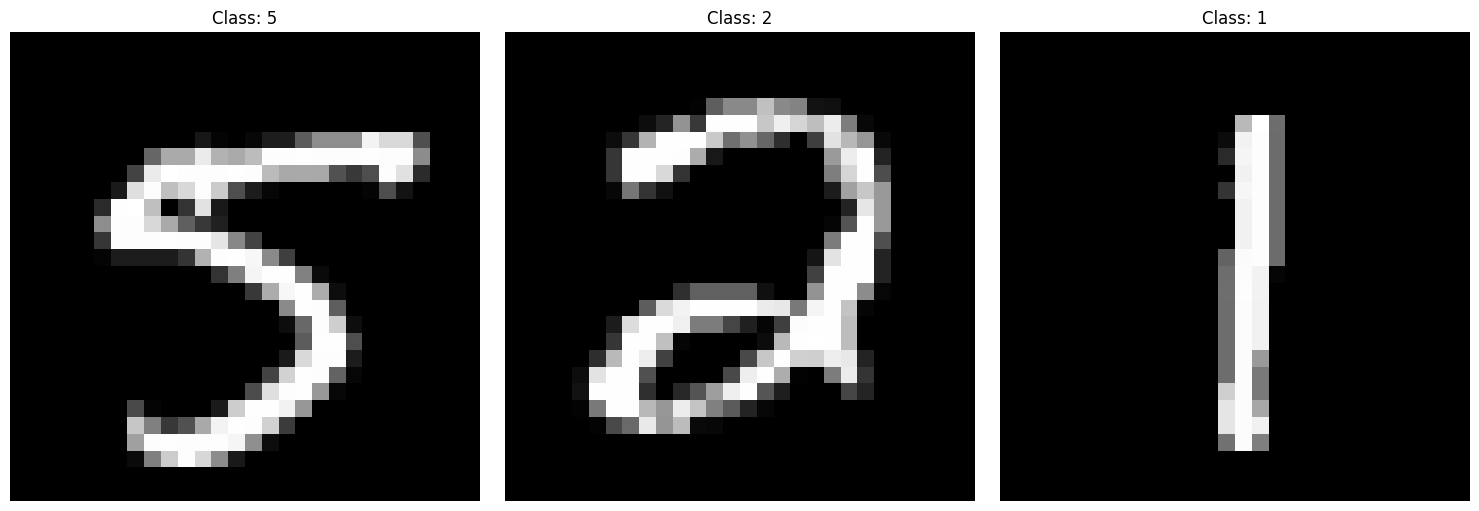

In [ ]:
# We first consider random indices of images

index_list = [102, 106, 180]

num_images = len(index_list)
img_list = []

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i, index in enumerate(index_list):
    testI2, testY2 = mnist_test.__getitem__(index)
    img_list.append((testI2, testY2))
    axes[i].imshow(testI2.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
    axes[i].set_title(f"Class: {testY2}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

The true class is 5, the new class will be 3
Iter 20/500, Value of c: 0.018061
Iter 40/500, Value of c: 0.032620
Iter 60/500, Value of c: 0.058916
Iter 80/500, Value of c: 0.106409
Iter 100/500, Value of c: 0.192186
Iter 120/500, Value of c: 0.347110
Iter 140/500, Value of c: 0.626919
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 0.0


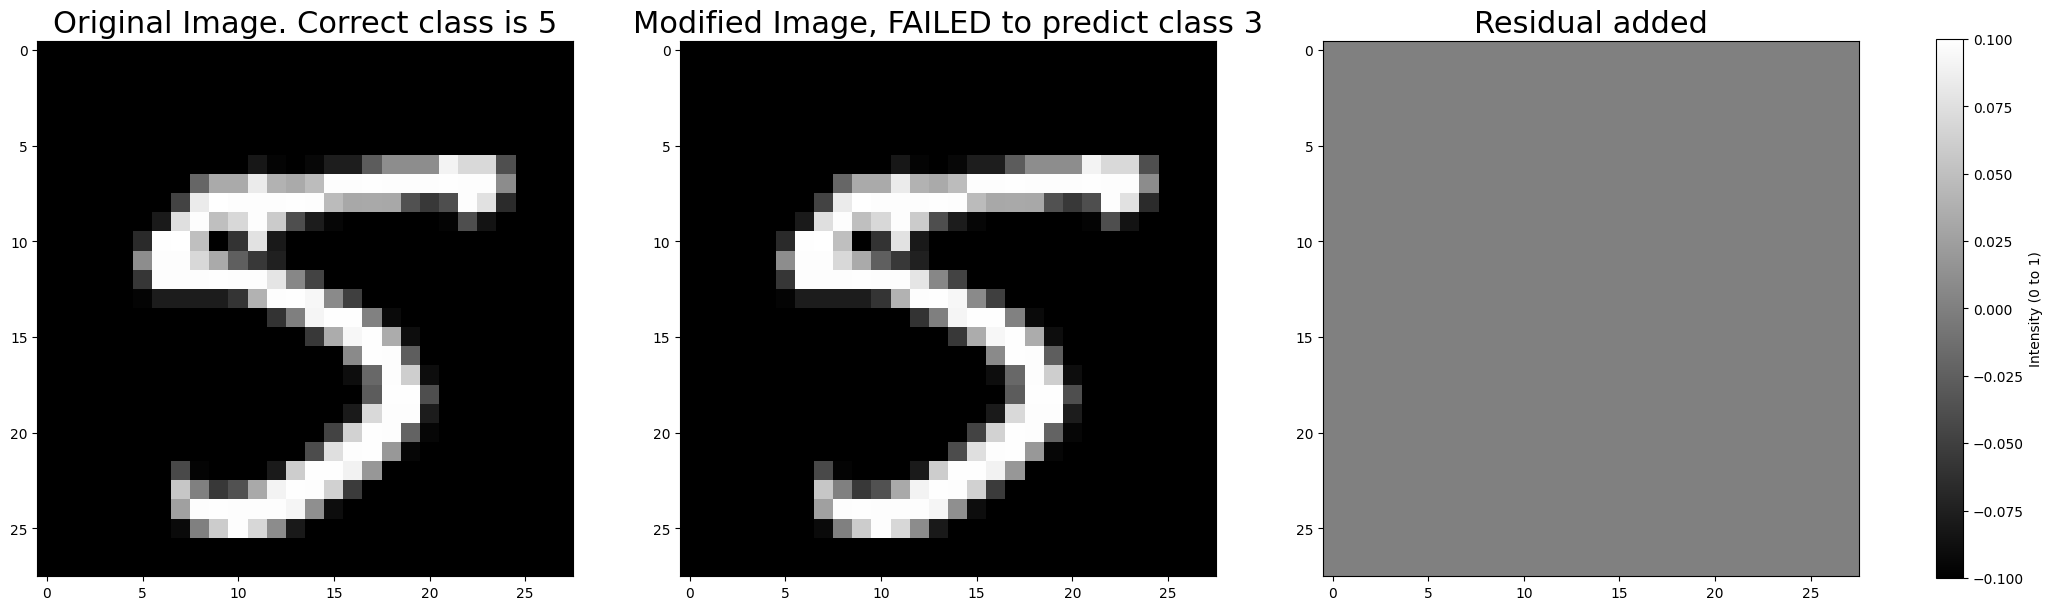

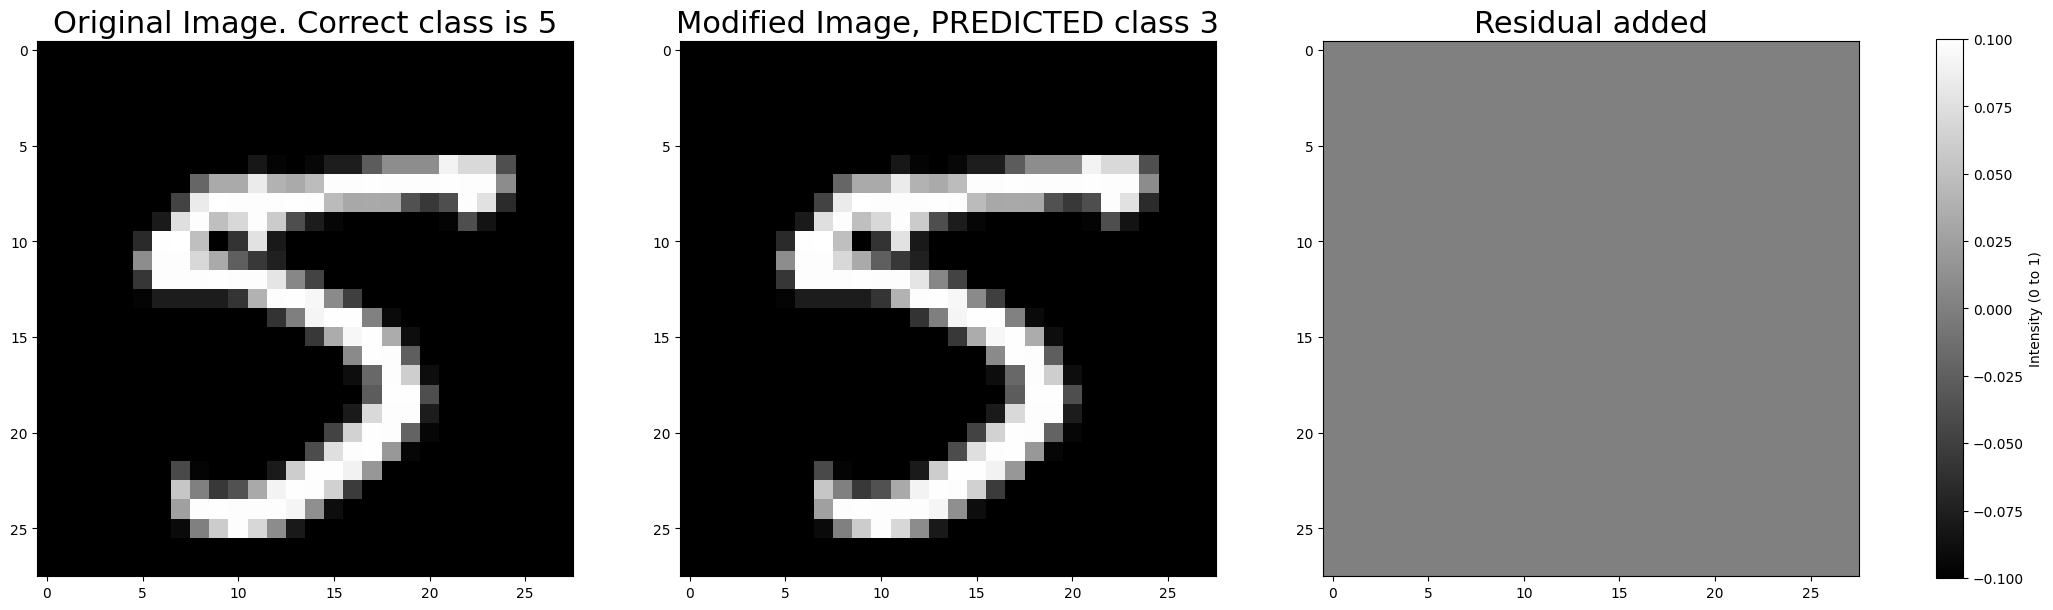

The true class is 2, the new class will be 7
Iter 20/500, Value of c: 0.018061
Iter 40/500, Value of c: 0.032620
Iter 60/500, Value of c: 0.058916
Iter 80/500, Value of c: 0.106409
Iter 100/500, Value of c: 0.192186
Iter 120/500, Value of c: 0.347110
Iter 140/500, Value of c: 0.626919
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 0.0


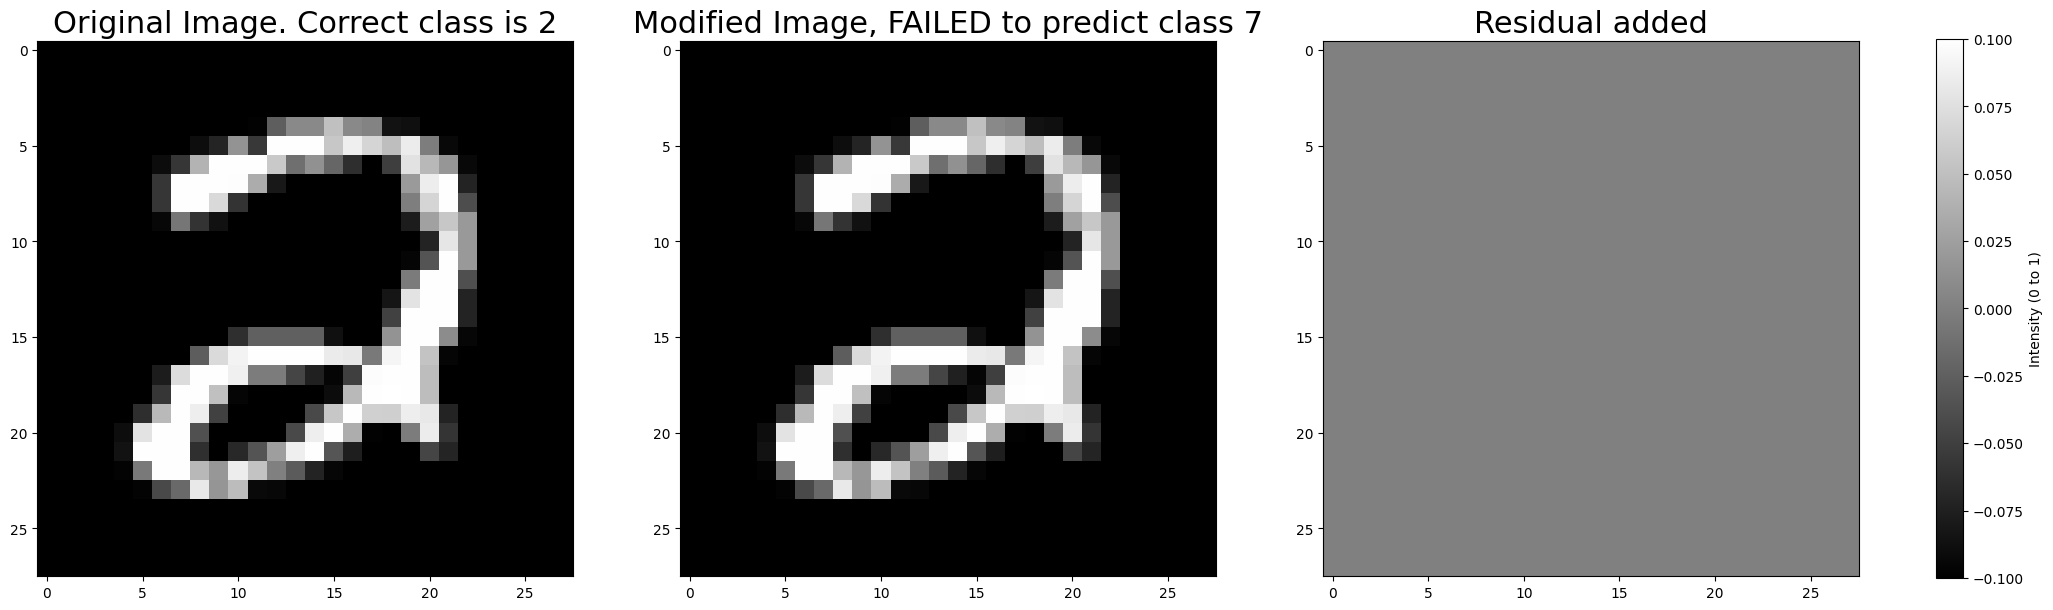

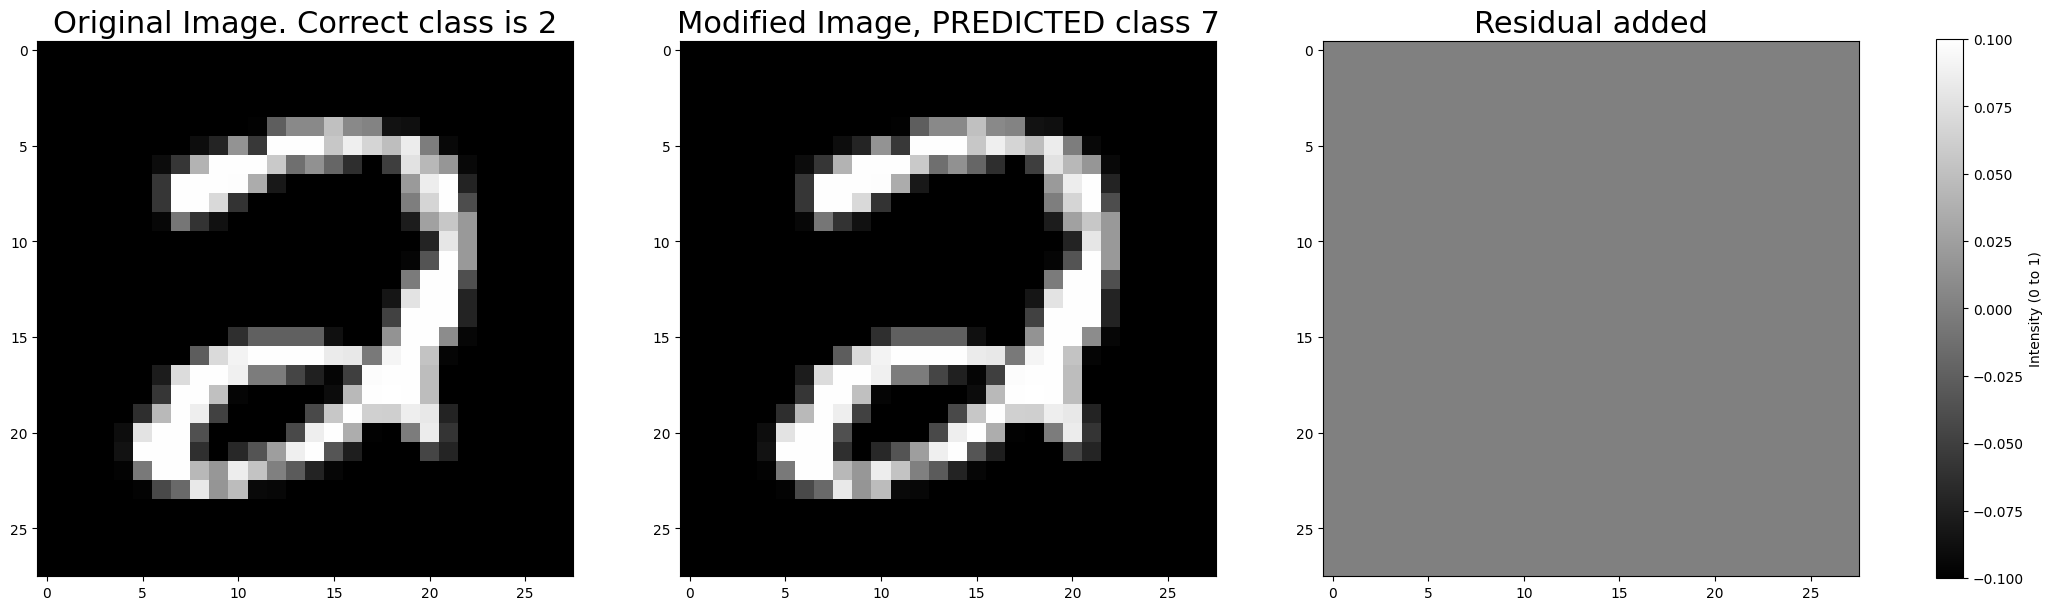

The true class is 1, the new class will be 6
Iter 20/500, Value of c: 0.018061
Iter 40/500, Value of c: 0.032620
Iter 60/500, Value of c: 0.058916
Iter 80/500, Value of c: 0.106409
Iter 100/500, Value of c: 0.192186
Iter 120/500, Value of c: 0.347110
Iter 140/500, Value of c: 0.626919
Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.
Norm Perturbation |r|: 0.0


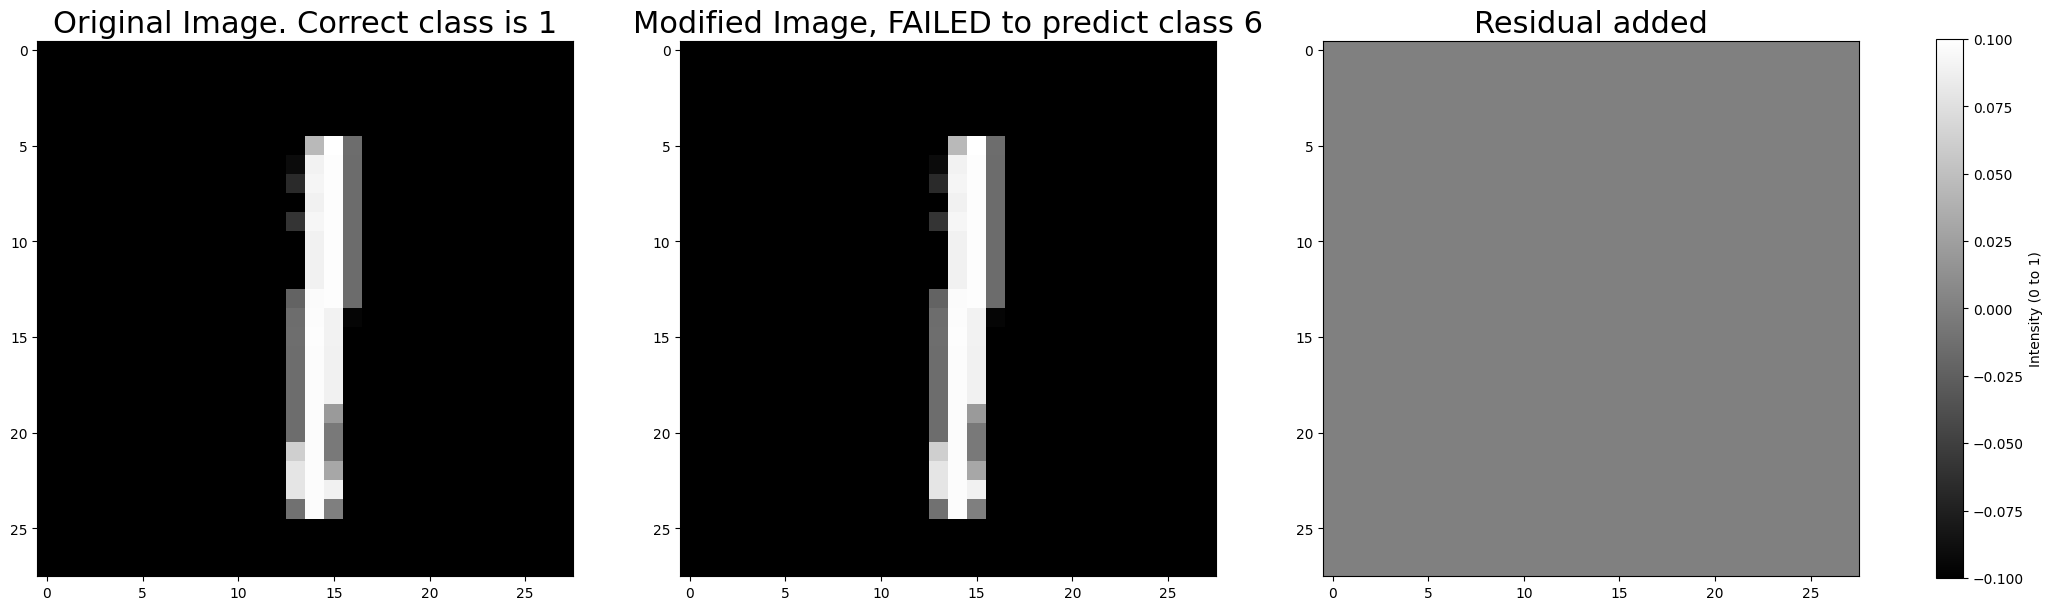

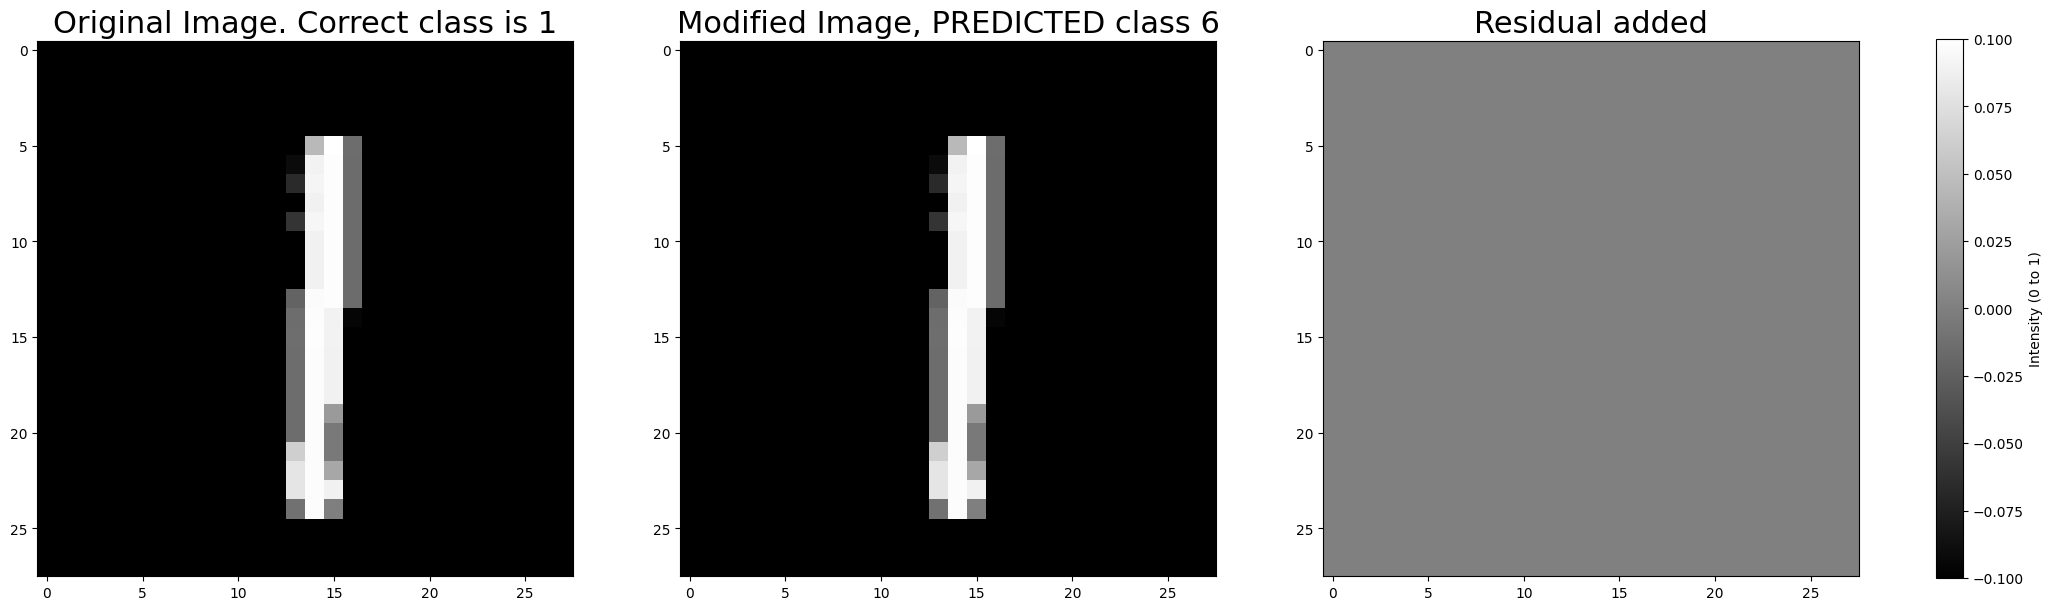

In [ ]:
# We define false labels, and prove the lack of convergence for some values of initial_c and max_c

false_labels = [3, 7, 6]
initial_c = 0.01
max_c = 1
mult_c = 1.03

for i, (testI, testY) in enumerate(img_list):
    procedure(model, testI, testY, false_labels[i], initial_c, max_c, mult_c)

The algorithm does not always converge as we can see.

We are now focused on hyperparameter tuning to make those 3 images looking to the false labels. Once done, we will conclude on the average distorsion of norm of r, and on the values of c preferred.

The true class is 5, the new class will be 3
Found c = 0.001900 satisfying f(x + r) = l
Optimization succeeded with c = 0.001900 in 1 iterations
Norm Perturbation |r|: 111.01153564453125


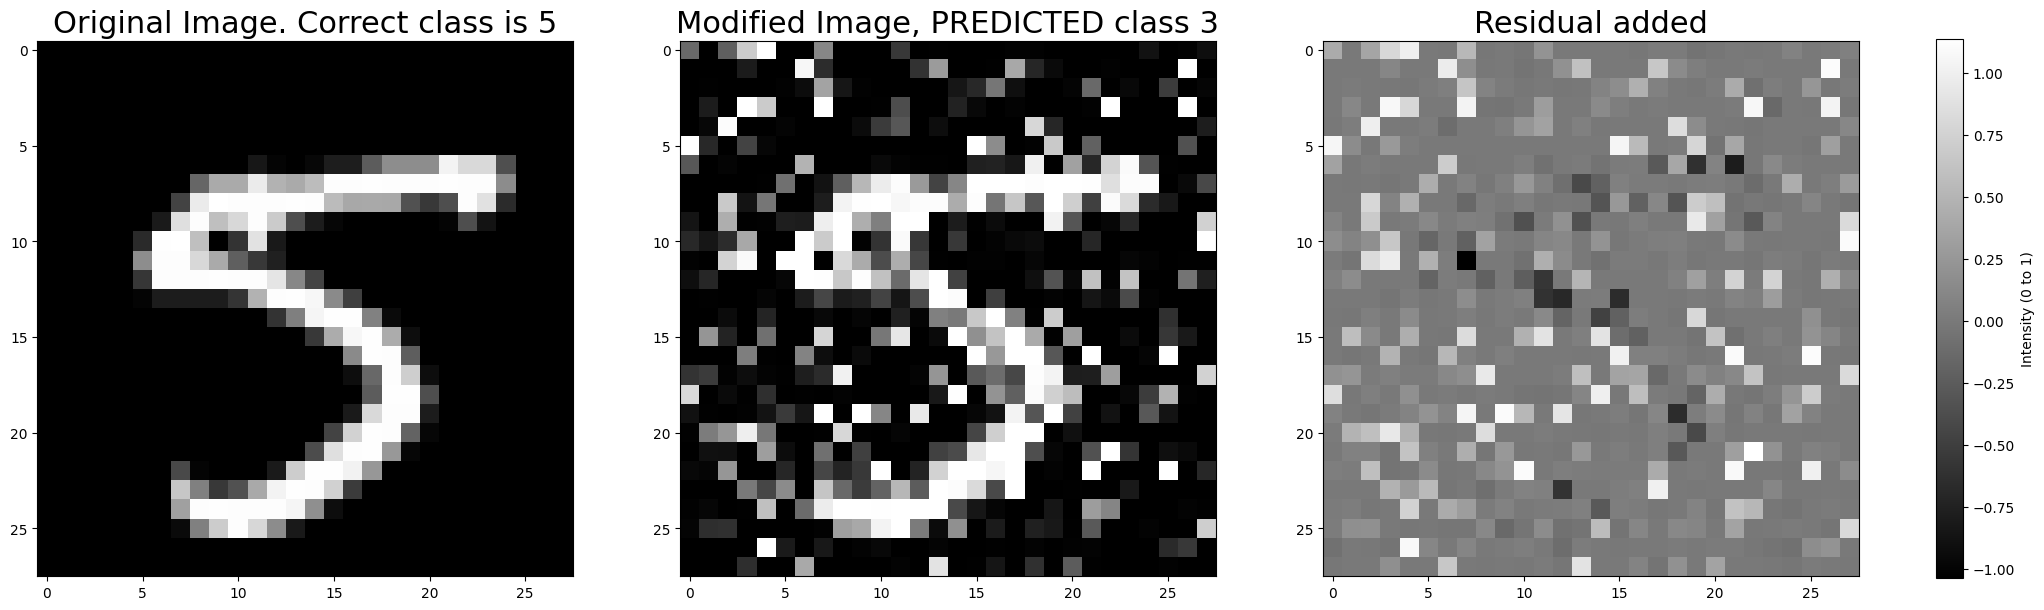

The true class is 2, the new class will be 7
Found c = 0.001957 satisfying f(x + r) = l
Optimization succeeded with c = 0.001957 in 2 iterations
Norm Perturbation |r|: 54.103450775146484


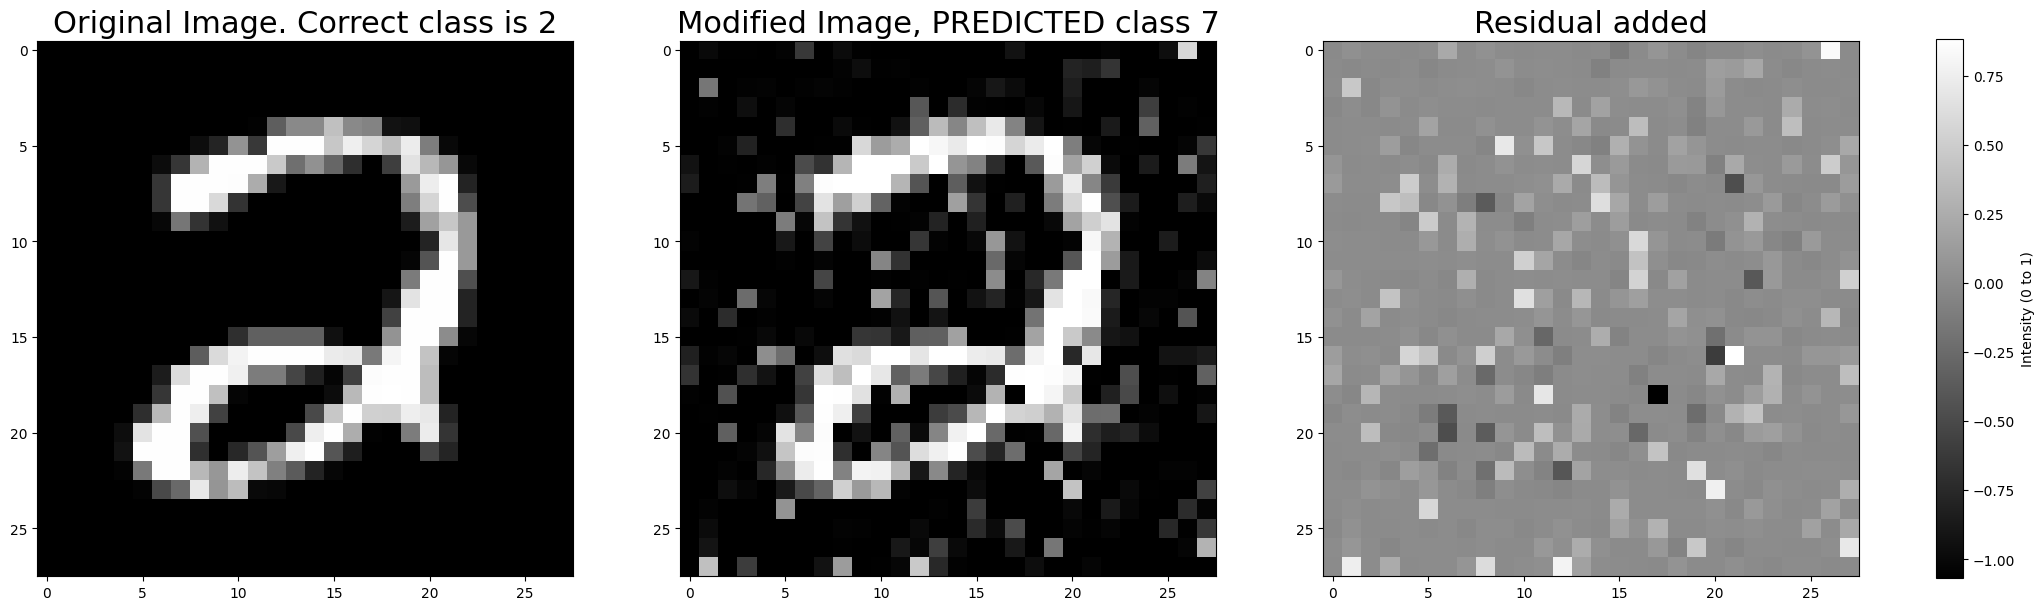

The true class is 1, the new class will be 6
Found c = 0.001900 satisfying f(x + r) = l
Optimization succeeded with c = 0.001900 in 1 iterations
Norm Perturbation |r|: 78.16934204101562


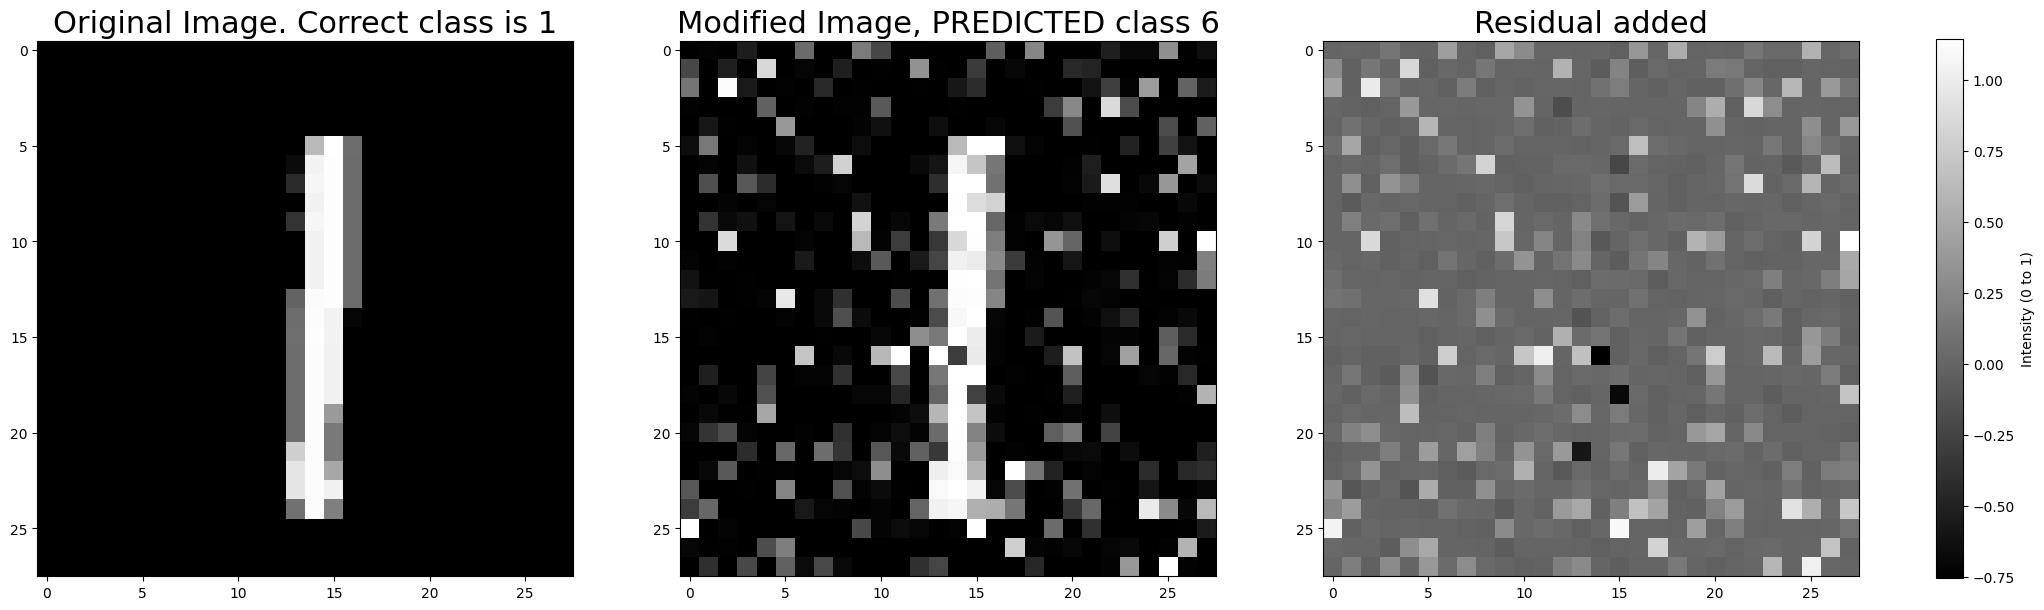

In [ ]:
max_iter_search=500
initial_c = 0.0019  # Initial value of c
max_c = 1  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

for i, (testI, testY) in enumerate(img_list):
    procedure(model, testI, testY, false_labels[i], initial_c, max_c, mult_c)

As either the algorithm converges very quickly (1 or 2 iterations), either it does not converge at all, the critical hyperparameter and the only one to have a deep impact on the generation of adversarial examples is "initial_c". After many tries, for those 3 images, we found that the best possible "c" is the biggest one where the algorithm still converges, i.e. 0.0019 for our 3 images. We should have done more tries to have a precise estimator of |r| but is equal to 81.09 here. Finally, the modified images look like the original labels with a bit of noise of it. Therefore, there are quite good adversarial examples.

**Question** What if you try with different networks ? Test with al least another network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed.

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

The true class is 5, the new class will be 3
Found c = 0.000124 satisfying f(x + r) = l
Optimization succeeded with c = 0.000124 in 2 iterations
Norm Perturbation |r|: 240.09878540039062


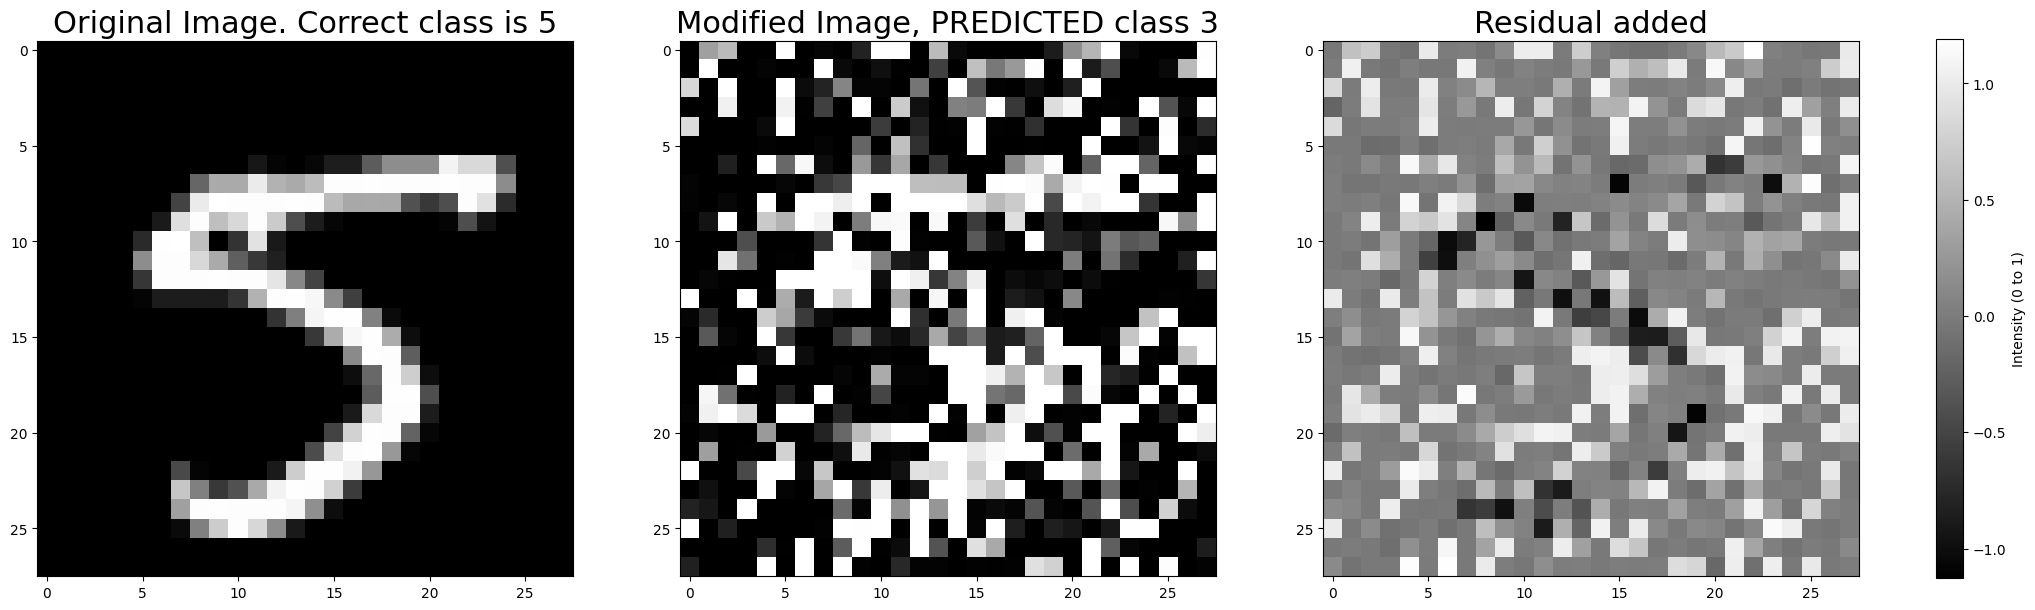

The true class is 2, the new class will be 7
Found c = 0.000120 satisfying f(x + r) = l
Optimization succeeded with c = 0.000120 in 1 iterations
Norm Perturbation |r|: 398.4607849121094


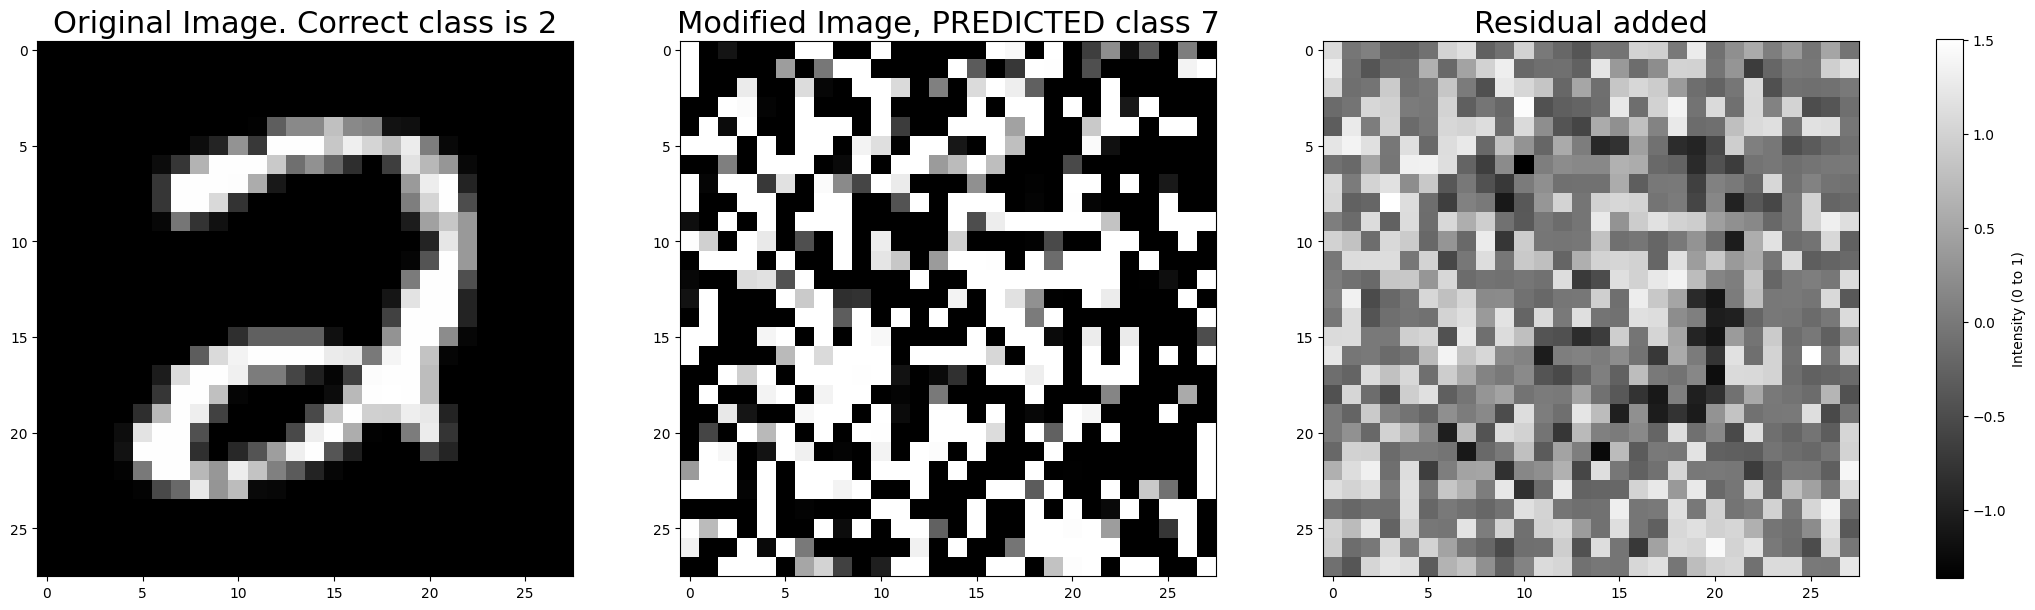

The true class is 1, the new class will be 6
Found c = 0.000120 satisfying f(x + r) = l
Optimization succeeded with c = 0.000120 in 1 iterations
Norm Perturbation |r|: 334.89044189453125


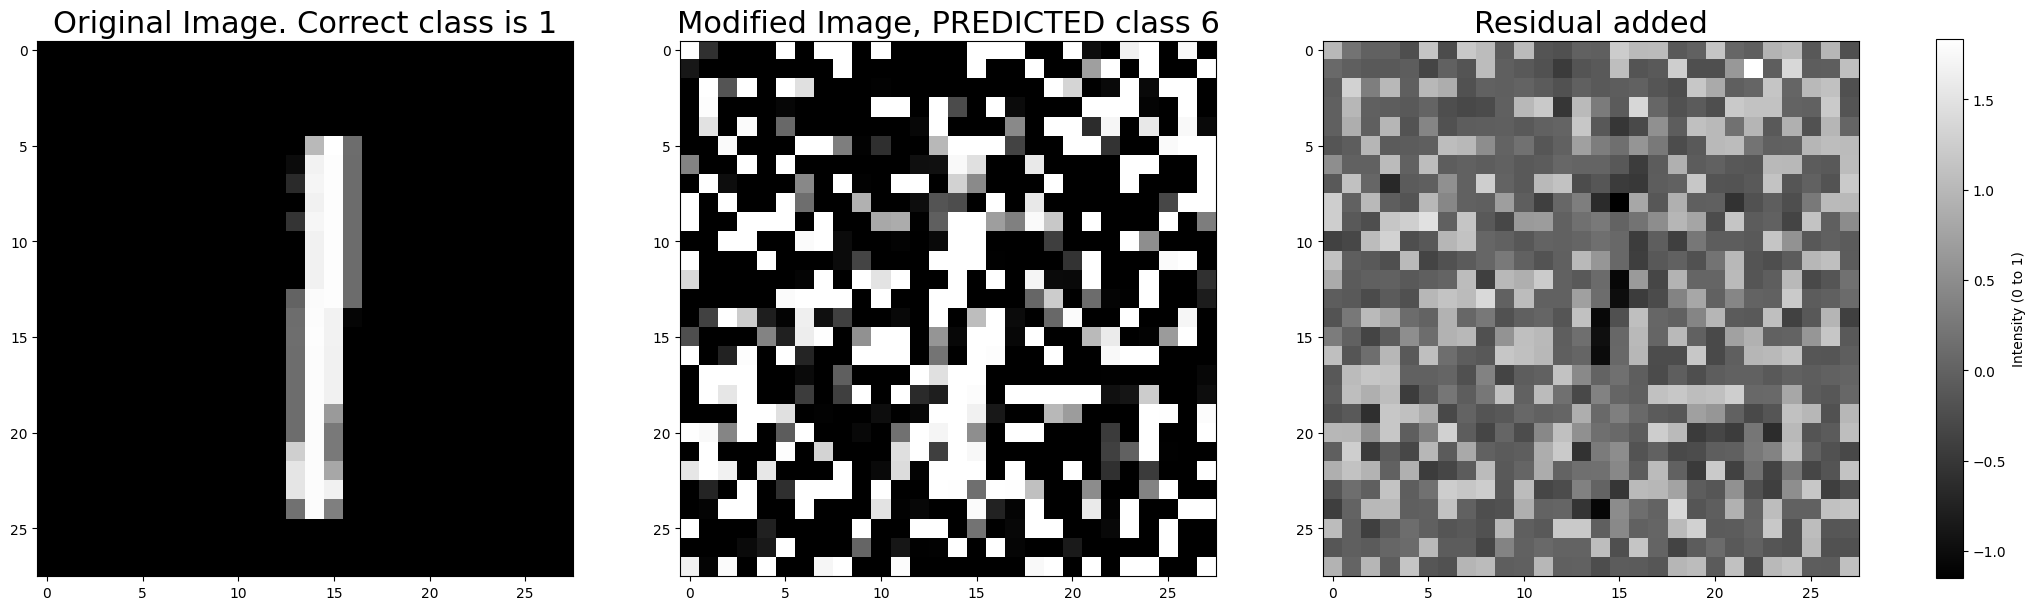

In [ ]:
# First we try with our second model created before, 3 hidden layers instead of 2.

max_iter_search=500
initial_c = 0.00012  # Initial value of c
max_c = 1  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

for i, (testI, testY) in enumerate(img_list):
    procedure(model3, testI, testY, false_labels[i], initial_c, max_c, mult_c)

With this "deeper" model, the best possible "c" found is lower : around 0.00012. The logic is the same as before, but now, the average |r| is much higher and the modified images contain to much noise to be chosen as good adversarial examples.

We now check the cross-network performance, feeding to the "deeper" model, the relatively good adversarial examples generated with the first one.

In [ ]:
def create_adversarial(model, testI, testY, label, initial_c, max_c, mult_c, lr_LBFGS=0.1, max_iter_LBFGS=100, plot=True):
    testI=testI.to(device)
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
    # manually chosen target class label different from true one
    l = torch.tensor([label]).to(device)
    l=l.to(device)
    l = l.view(1) # to have a batch size equal to 1 and work with CrossEntropy loss
    print(f"The true class is {testY}, the new class will be {l[0]}")
    loss_f = nn.CrossEntropyLoss()

    def objective(c, r, x, l):
        x_r = torch.clamp(x + r, 0, 1)
        pred = model(x_r)
        return c*torch.abs(r).sum() + loss_f(pred, l)

    # Line search to find the minimum c > 0
    c = initial_c
    iter=0
    while (c <= max_c) and (iter <= max_iter_search):
        # Define the optimizer (Box-Constrained L-BFGS)
        optimizerLBFGS = optimizerLBFGS = optim.LBFGS([r],
                                                    lr=lr_LBFGS,
                                                    max_iter=max_iter_LBFGS,
                                                    tolerance_grad=epsilon_LBFGS,
                                                    tolerance_change=epsilon_LBFGS,
                                                    line_search_fn='strong_wolfe'
                                                    )
        def closure():
            optimizerLBFGS.zero_grad()
            loss = objective(c, r, testI, l)
            loss.backward()
            return loss

        # Perform optimization
        optimizerLBFGS.step(closure)

        # Evaluate the condition f(x + r) = l
        with torch.no_grad():
            x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)

        # Check if the condition f(x + r) = l is satisfied
        if predicted_label == l:
            print(f"Found c = {c:.6f} satisfying f(x + r) = l")
            iter=iter+1
            break
        else:
            iter=iter+1

        # If not satisfied, increase c
        c *= mult_c # Adjust step size for line search
        if (iter) % 20 == 0:
            print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

    if (c > max_c) or (iter > max_iter_search):
        print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

        plot_results(testI, r, x_r, testY, l, fail=True)

    else:
        print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
        #print(f"Perturbation r: {r}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")

    if plot:
        plot_results(testI, r, x_r, testY, l, fail=False)

    return x_r

In [ ]:
initial_c = 0.0019
max_c = 0.01 # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

for i, (testI, testY) in enumerate(img_list):
    x_r = create_adversarial(model, testI, testY, false_labels[i], initial_c, max_c, mult_c, plot=False)
    pred = torch.argmax(model3(x_r), dim=1)
    print("*************")
    print("1 = missclassified (good adversarial examples)")
    print("0 = good classification")
    print(f"Answer: {int(pred != testY)}")
    print("*************")

The true class is 5, the new class will be 3
Found c = 0.001900 satisfying f(x + r) = l
Optimization succeeded with c = 0.001900 in 1 iterations
Norm Perturbation |r|: 111.01153564453125
*************
1 = missclassified (good adversarial examples)
0 = good classification
Answer: 1
*************
The true class is 2, the new class will be 7
Found c = 0.001957 satisfying f(x + r) = l
Optimization succeeded with c = 0.001957 in 2 iterations
Norm Perturbation |r|: 54.103450775146484
*************
1 = missclassified (good adversarial examples)
0 = good classification
Answer: 1
*************
The true class is 1, the new class will be 6
Found c = 0.001900 satisfying f(x + r) = l
Optimization succeeded with c = 0.001900 in 1 iterations
Norm Perturbation |r|: 78.16934204101562
*************
1 = missclassified (good adversarial examples)
0 = good classification
Answer: 1
*************


For our 3 examples, we observe that the "deeper" model missclassify the 3 labels, convincing us that these are good adversarial examples.

Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c.

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Would you minimize or maximize c ? Please comment on that.

First we fix *c* and only estimate *r* using Adam.

In [ ]:
testI, testY = mnist_test.__getitem__(150)
print(f"the true label is: {testY}")

the true label is: 9


Optimization succeeded at iteration 318 with fixed c = 0.005
Norm Perturbation |r|: 13.055533409118652


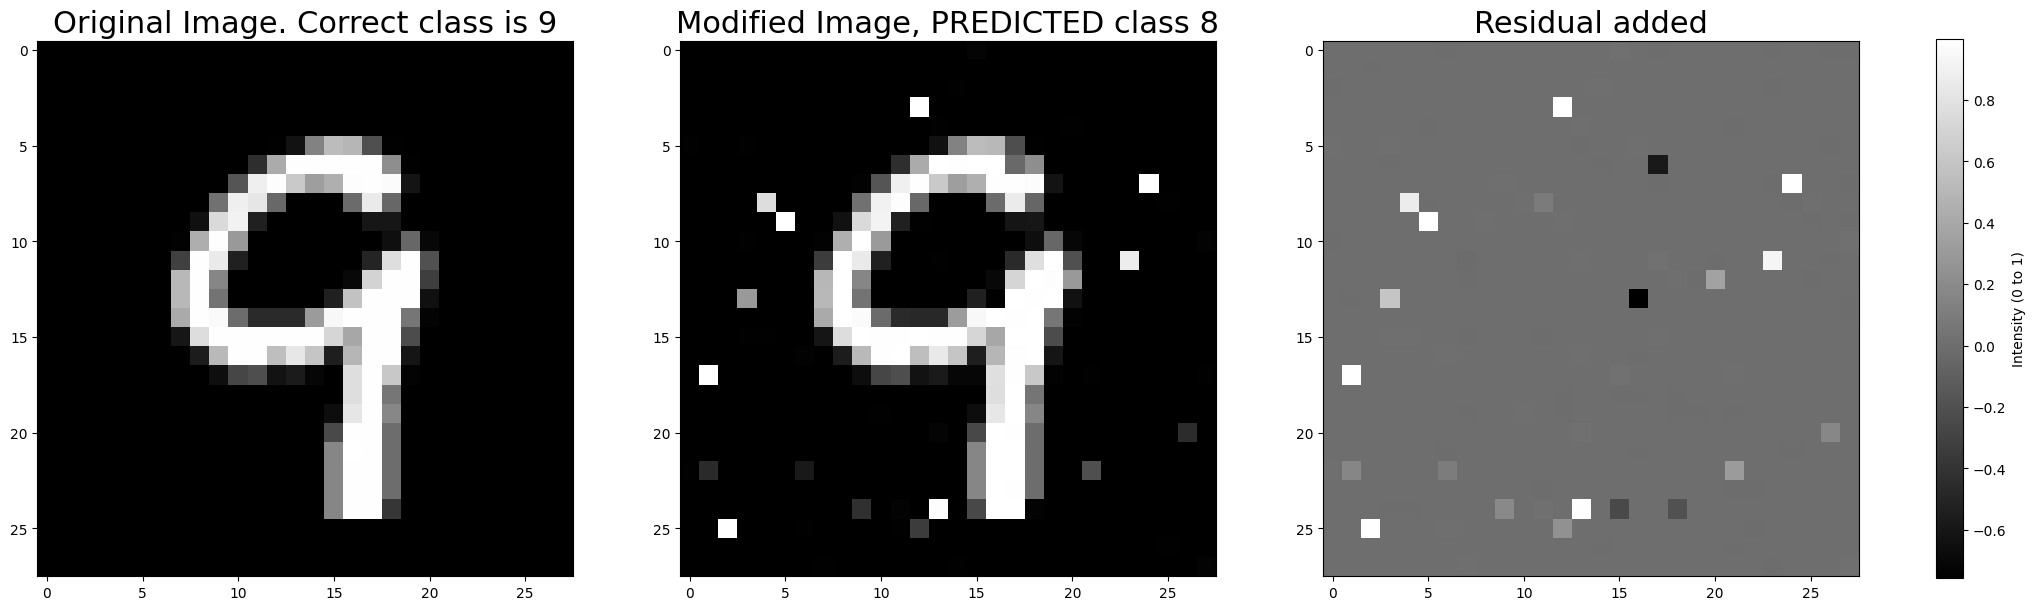

In [ ]:
max_iter = 1000
lr = 0.01

# Parameters
c = 0.005  # Fixed value for c
testI = testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)
optimizer = optim.Adam([r], lr=lr)
criterion = nn.CrossEntropyLoss()
l = torch.tensor([8], device=device) # false label


for iter in range(max_iter):
    optimizer.zero_grad()

    x_r = torch.clamp(testI + r, 0, 1)

    # Forward pass and compute loss
    pred = model(x_r)
    loss = criterion(pred, l) + c * torch.norm(r, p=1)

    # Backpropagation and update r
    loss.backward()
    optimizer.step()

    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition is satisfied
    if predicted_label == l:
        print(f"Optimization succeeded at iteration {iter} with fixed c = {c}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
        plot_results(testI, r, x_r, testY, l, fail=False)
        break
else:
    print("Failed to find adversarial example within the maximum iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=True)

This works well with a value of *c* equals to 0.005. Visually, the modified image is a really good adversarial example. We try now by estimating both *c* and *r*.

Optimization succeeded at iteration 20 with fixed c = 0.005
Norm Perturbation |r|: 26.769142150878906


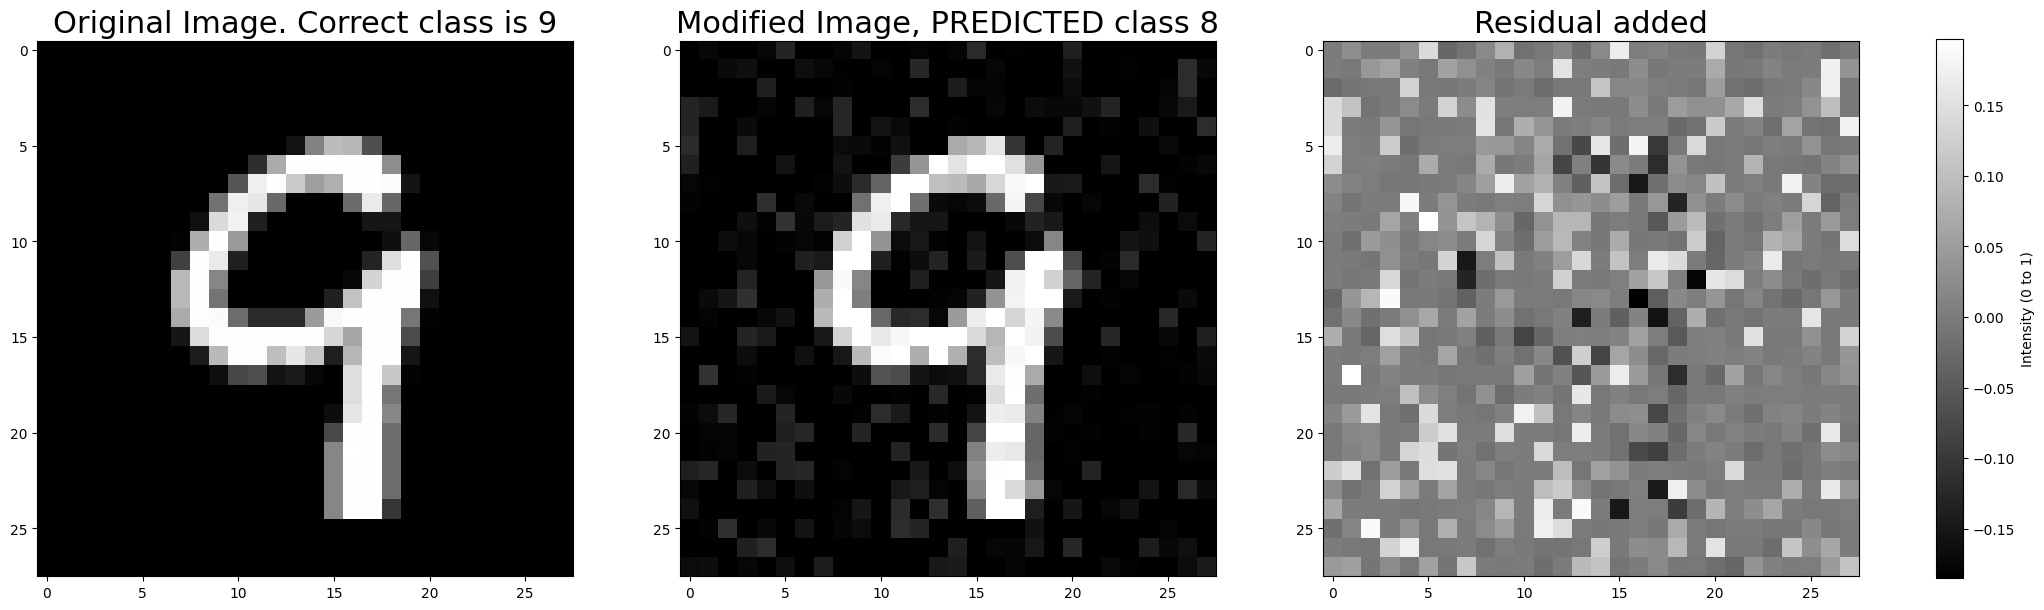

In [ ]:
max_iter = 1000
lr = 0.01

# Parameters
c_param = torch.tensor([0.001], requires_grad=True, device=device)
testI = testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)
optimizer = optim.Adam([r, c_param], lr=lr) # We add c to the optimizer now
criterion = nn.CrossEntropyLoss()
l = torch.tensor([8], device=device) # false label

for iter in range(max_iter):
    optimizer.zero_grad()

    x_r = torch.clamp(testI + r, 0, 1)

    # Forward pass and compute loss
    pred = model(x_r)
    current_c = torch.abs(c_param)
    loss = criterion(pred, l) + current_c * torch.norm(r, p=1)

    # Backpropagation and update r
    loss.backward()
    optimizer.step()

    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition is satisfied
    if predicted_label == l:
        print(f"Optimization succeeded at iteration {iter} with fixed c = {c}")
        print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
        plot_results(testI, r, x_r, testY, l, fail=False)
        break
else:
    print("Failed to find adversarial example within the maximum iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=True)

We observe that it works properly too, the adversarial example is good and the algorithm converges rapidly. *c* is optimized to 0.05, the same value found manually before. We finally try with a ridge penalty to observe if we obtain better results, as it helps to promote small diffuse values and prevents noise from being concentrated on a few pixels.

Optimization succeeded at iteration 11 with fixed c = 0.005
Norm Perturbation L2: 1.972618579864502


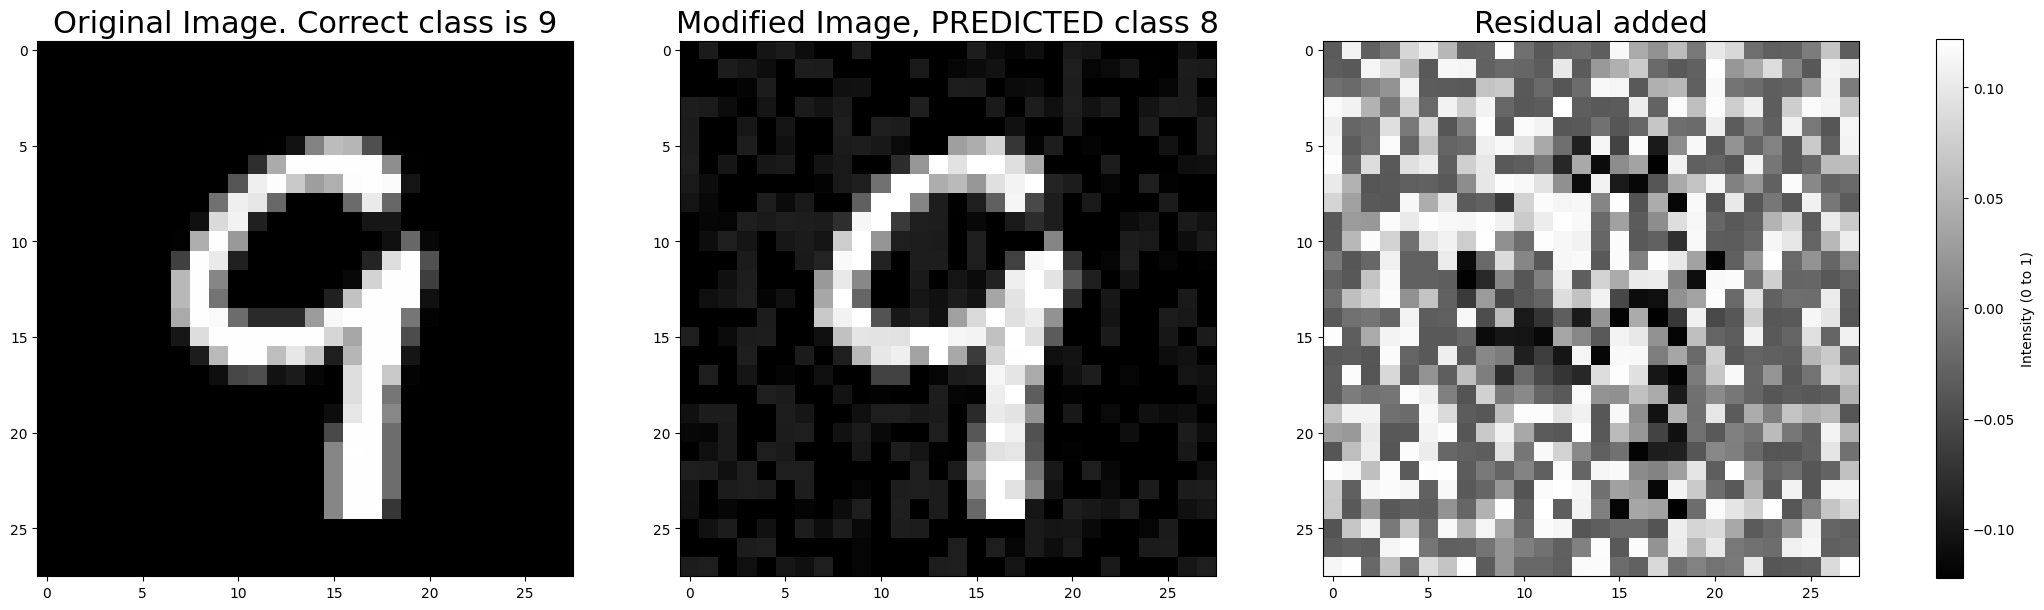

In [ ]:
max_iter = 1000
lr = 0.01

# Parameters
c_param = torch.tensor([0.001], requires_grad=True, device=device)
testI = testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)
optimizer = optim.Adam([r, c_param], lr=lr) # We add c to the optimizer now
criterion = nn.CrossEntropyLoss()
l = torch.tensor([8], device=device) # false label

for iter in range(max_iter):
    optimizer.zero_grad()

    x_r = torch.clamp(testI + r, 0, 1)

    # Forward pass and compute loss
    pred = model(x_r)
    current_c = torch.abs(c_param)
    loss = criterion(pred, l) + current_c * torch.norm(r, p=2)**2

    # Backpropagation and update r
    loss.backward()
    optimizer.step()

    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition is satisfied
    if predicted_label == l:
        print(f"Optimization succeeded at iteration {iter} with fixed c = {c}")
        print(f"Norm Perturbation L2: {torch.norm(r, p=2)}")
        plot_results(testI, r, x_r, testY, l, fail=False)
        break
else:
    print("Failed to find adversarial example within the maximum iterations")
    print(f"Norm Perturbation L2: {torch.norm(r, p=2)}")
    plot_results(testI, r, x_r, testY, l, fail=True)

We find a really good result with this penalty too, and the residual added seems to be more evenly distributed.

The objective was here to maximize *c*.

# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and J(θ, x, y) the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\Delta_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [10]:
# Parameters
index=10
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True # Important for attack
Y=torch.tensor([testY]).to(device)

torch.Size([1, 1, 28, 28])


And plot it.

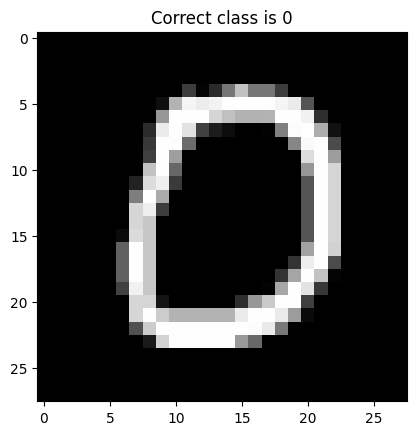

In [11]:
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

Original Class: 0, Perturbed Class: 1
Optimization succesfull
Norm Perturbation |r|: 78.4000015258789


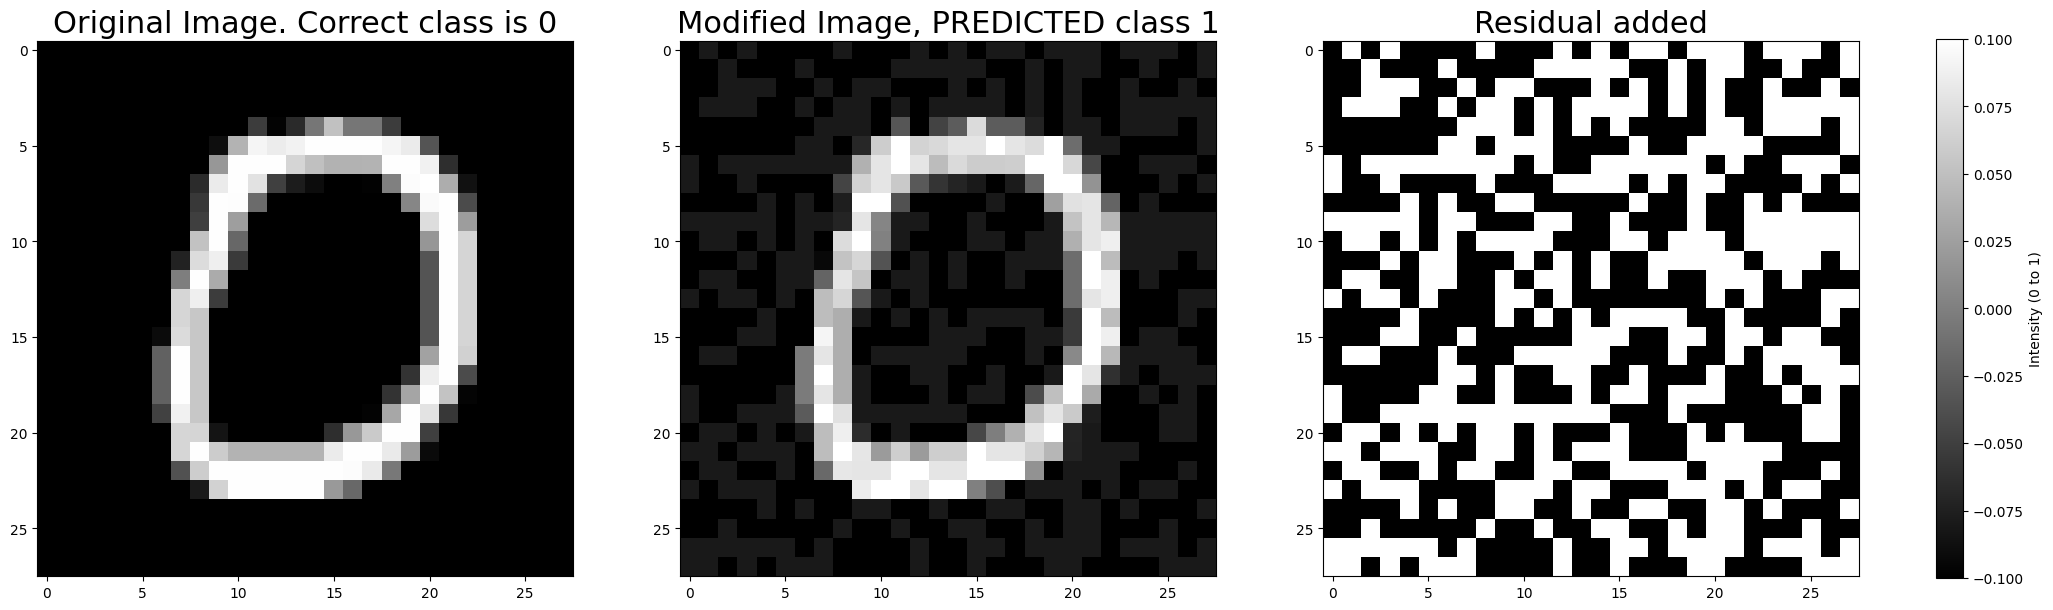

In [12]:
eps = 0.1 # perturbation size

# Forward pass of X through the model
pred_original = model(X)
original_class=torch.tensor([0], device=X.device)

# Compute loss
cost = torch.nn.CrossEntropyLoss()(pred_original, original_class)

# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()

# FGSM attack code
Xr = X + eps*X.grad.data.sign()
Xr = torch.clamp(Xr,0,1)

# Re-classify the perturbed image
pred_perturbed = model(Xr)
perturbed_class=pred_perturbed.argmax(dim=1)

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

r=eps*X.grad.data.sign()

if original_class.item()==perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)
else:
    print(f"Optimization succesfull")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)

Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created).

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

Using epsilon: 0.005 we successfully create 88.98% adversarial examples


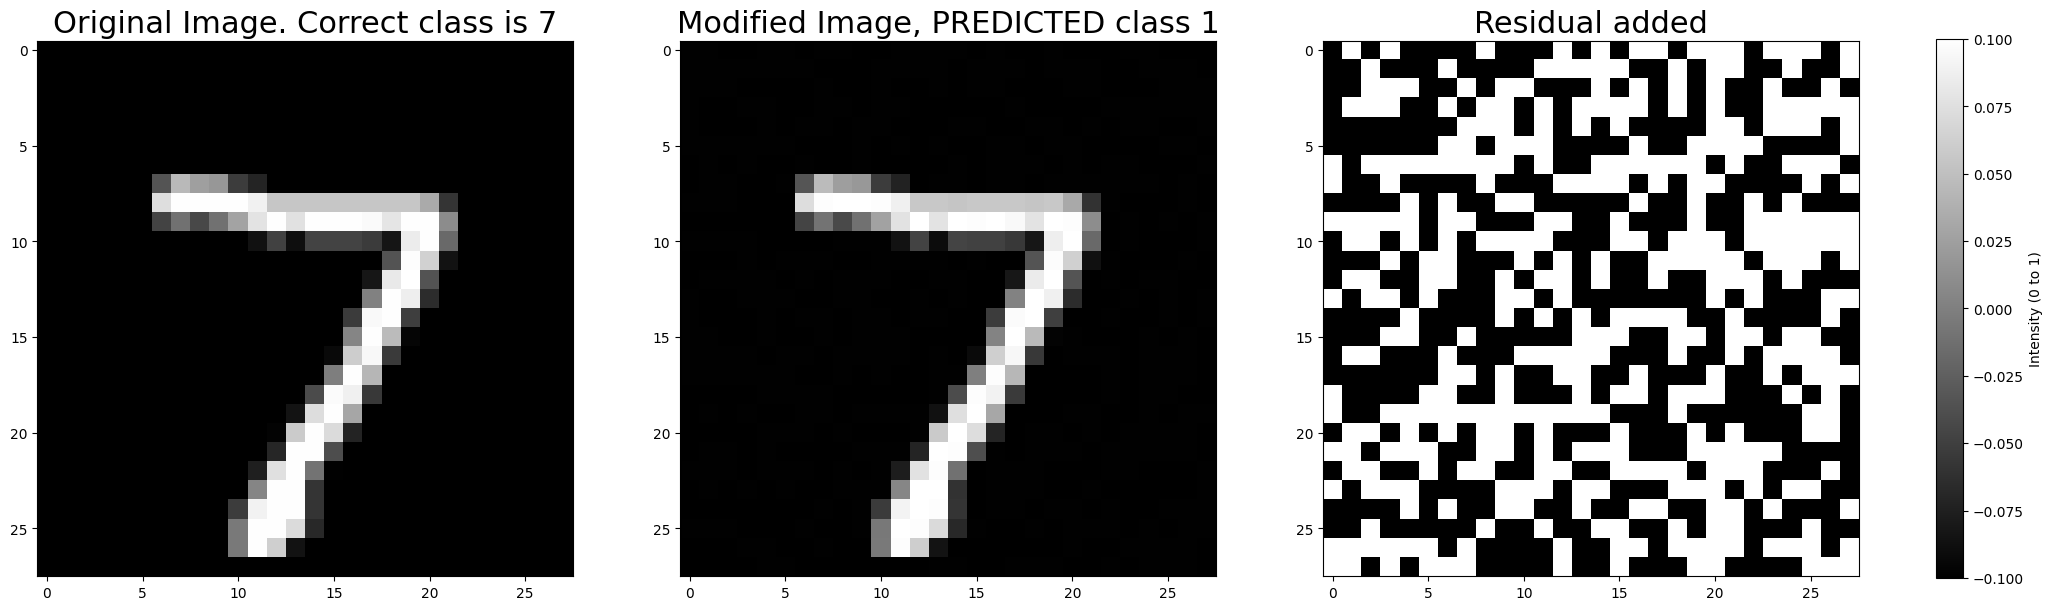

Using epsilon: 0.05 we successfully create 99.97% adversarial examples


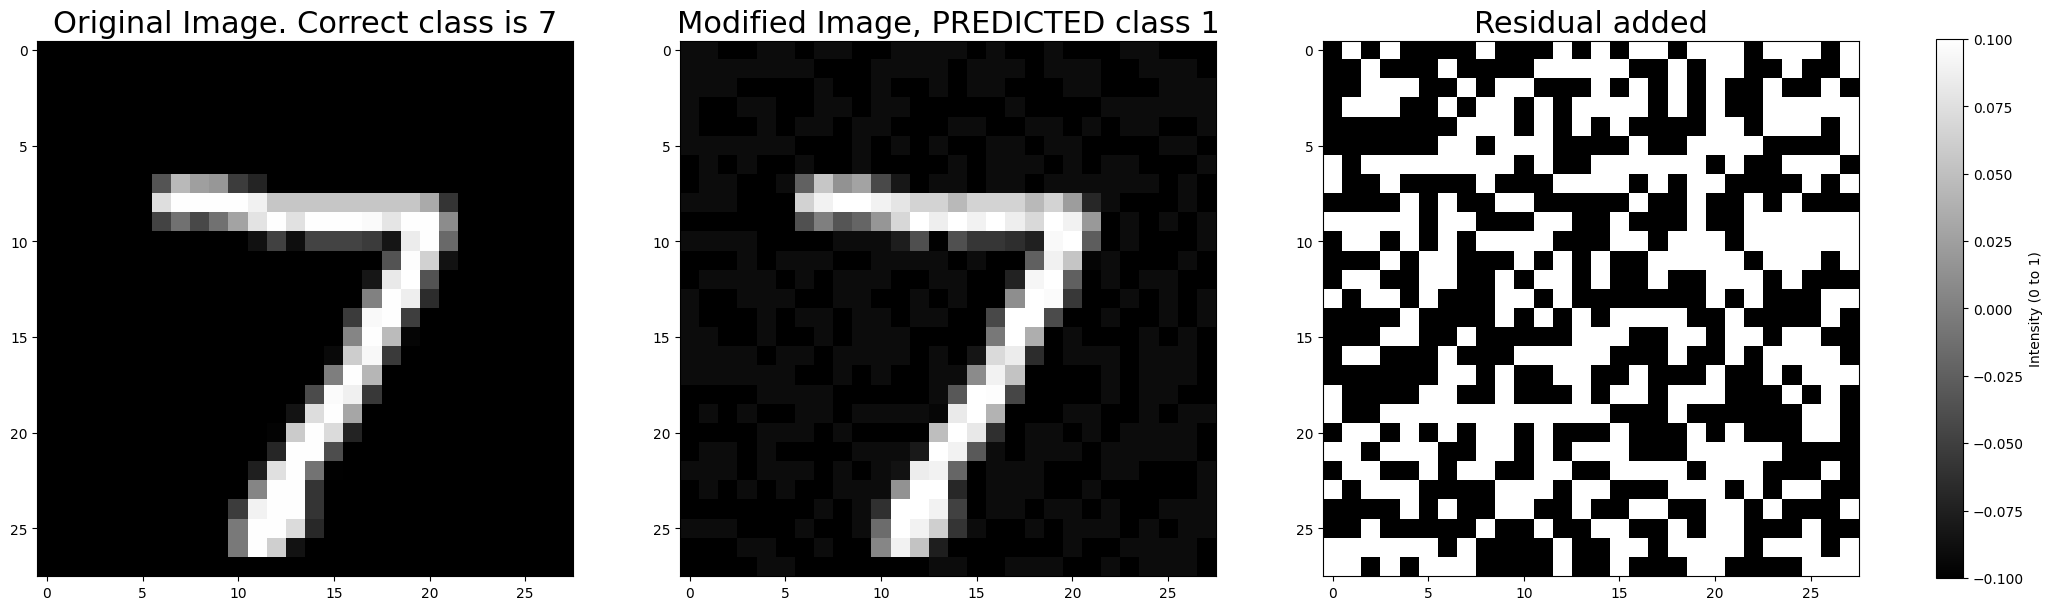

Using epsilon: 0.1 we successfully create 100.00% adversarial examples


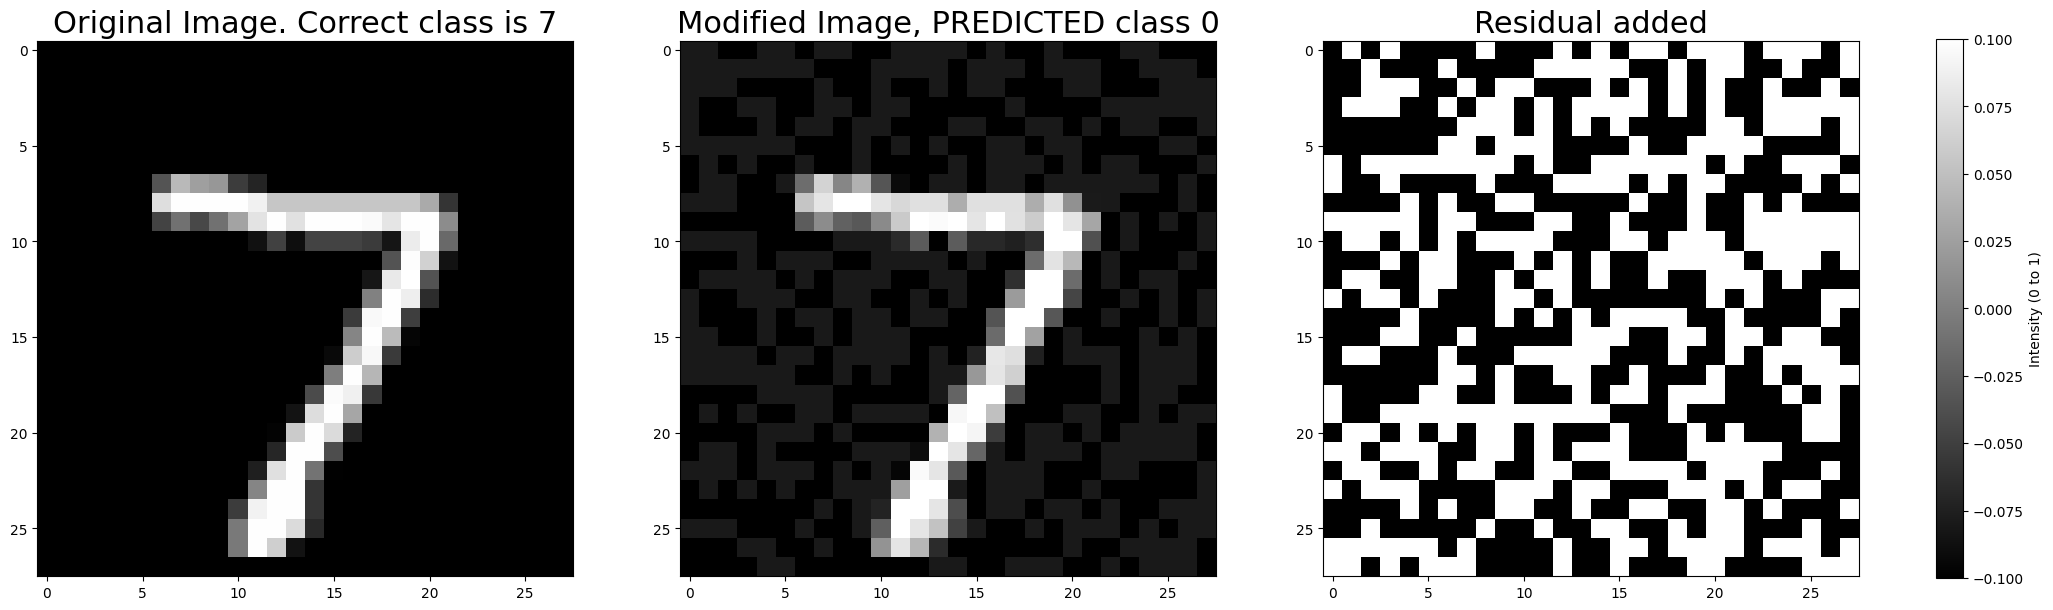

Using epsilon: 0.2 we successfully create 100.00% adversarial examples


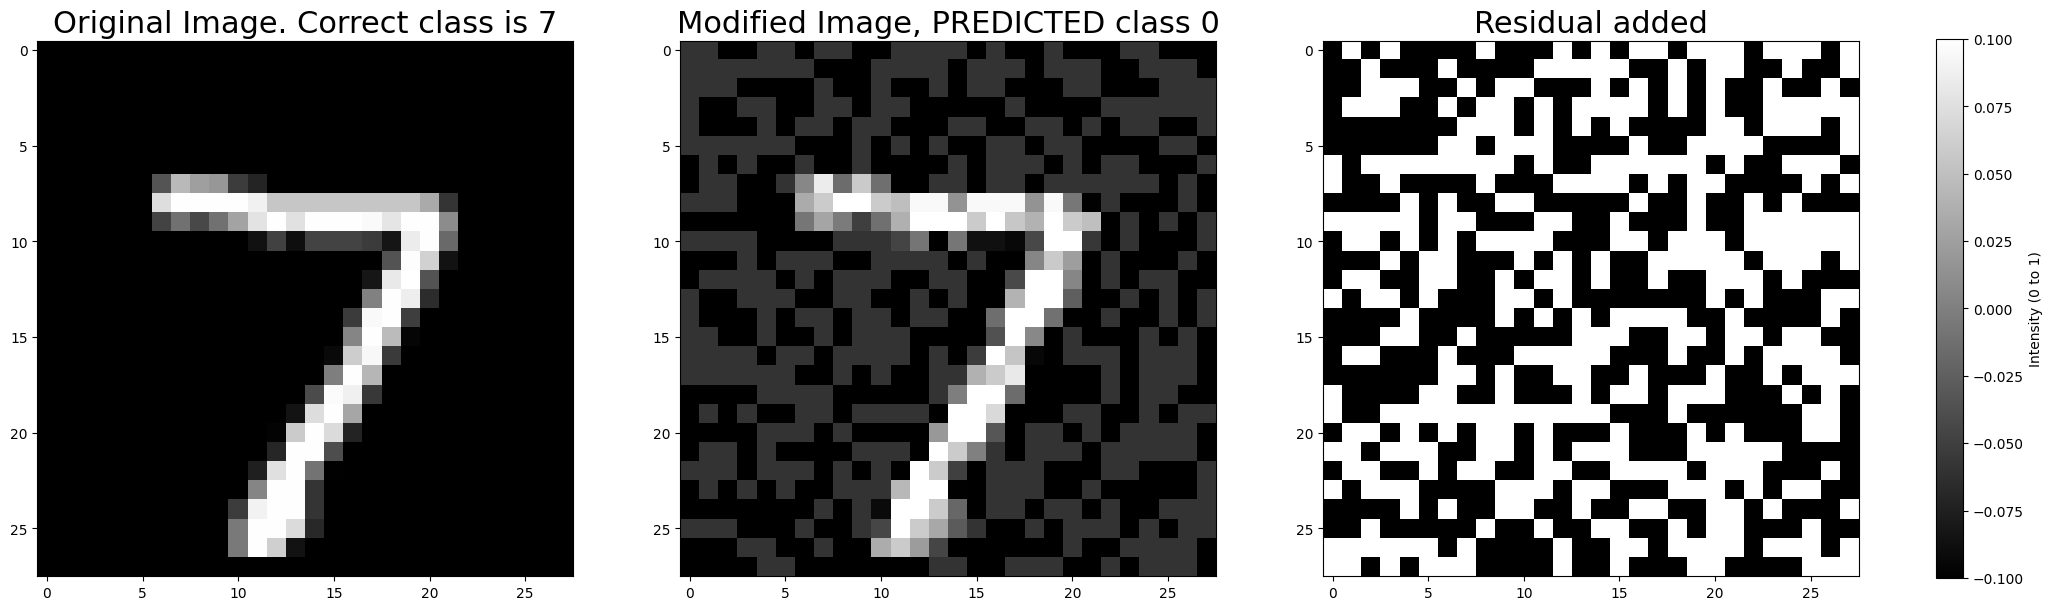

Using epsilon: 0.25 we successfully create 100.00% adversarial examples


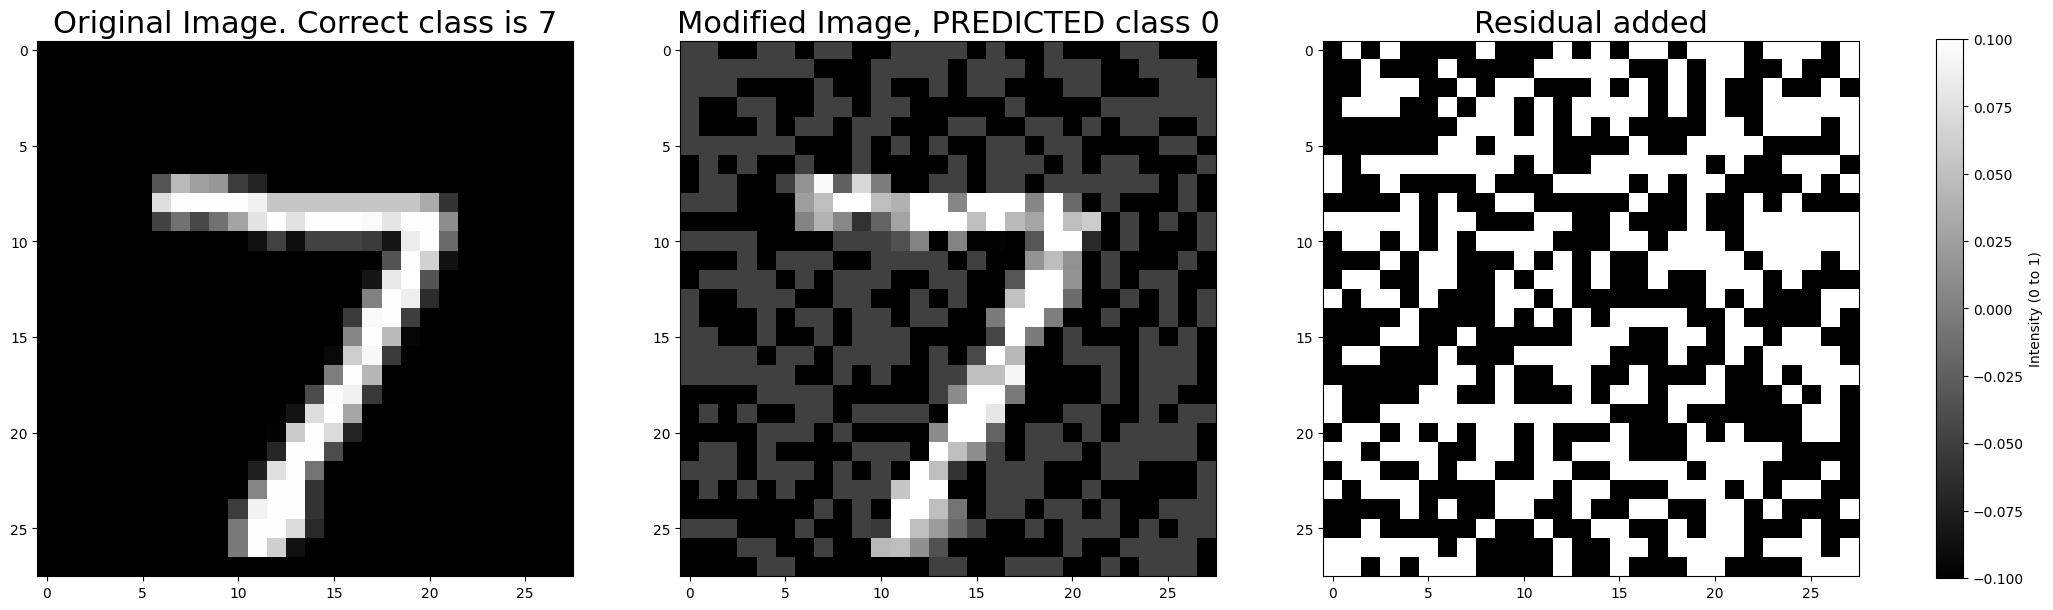

Using epsilon: 0.5 we successfully create 100.00% adversarial examples


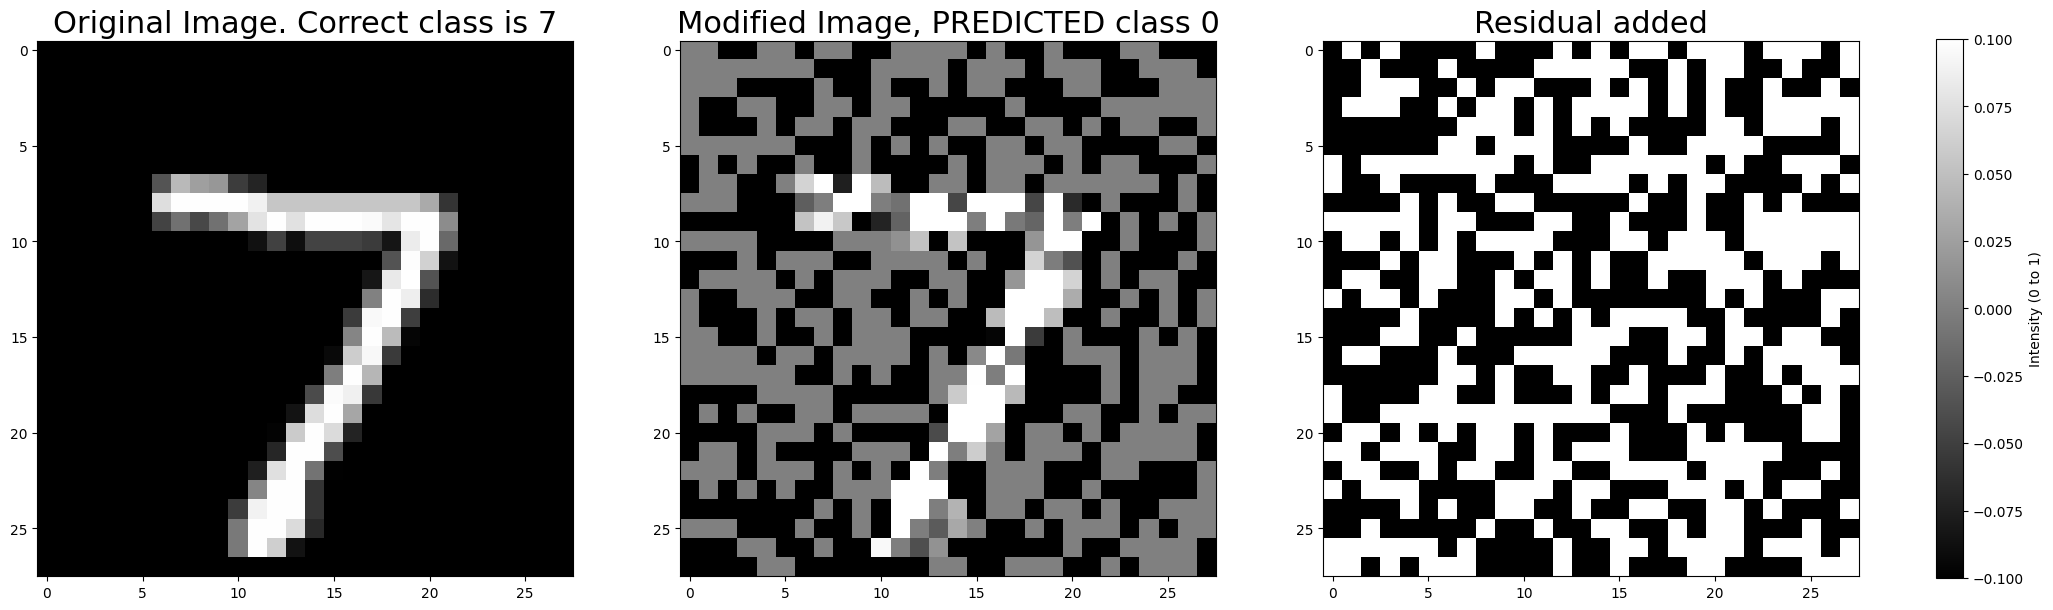

Using epsilon: 0.75 we successfully create 100.00% adversarial examples


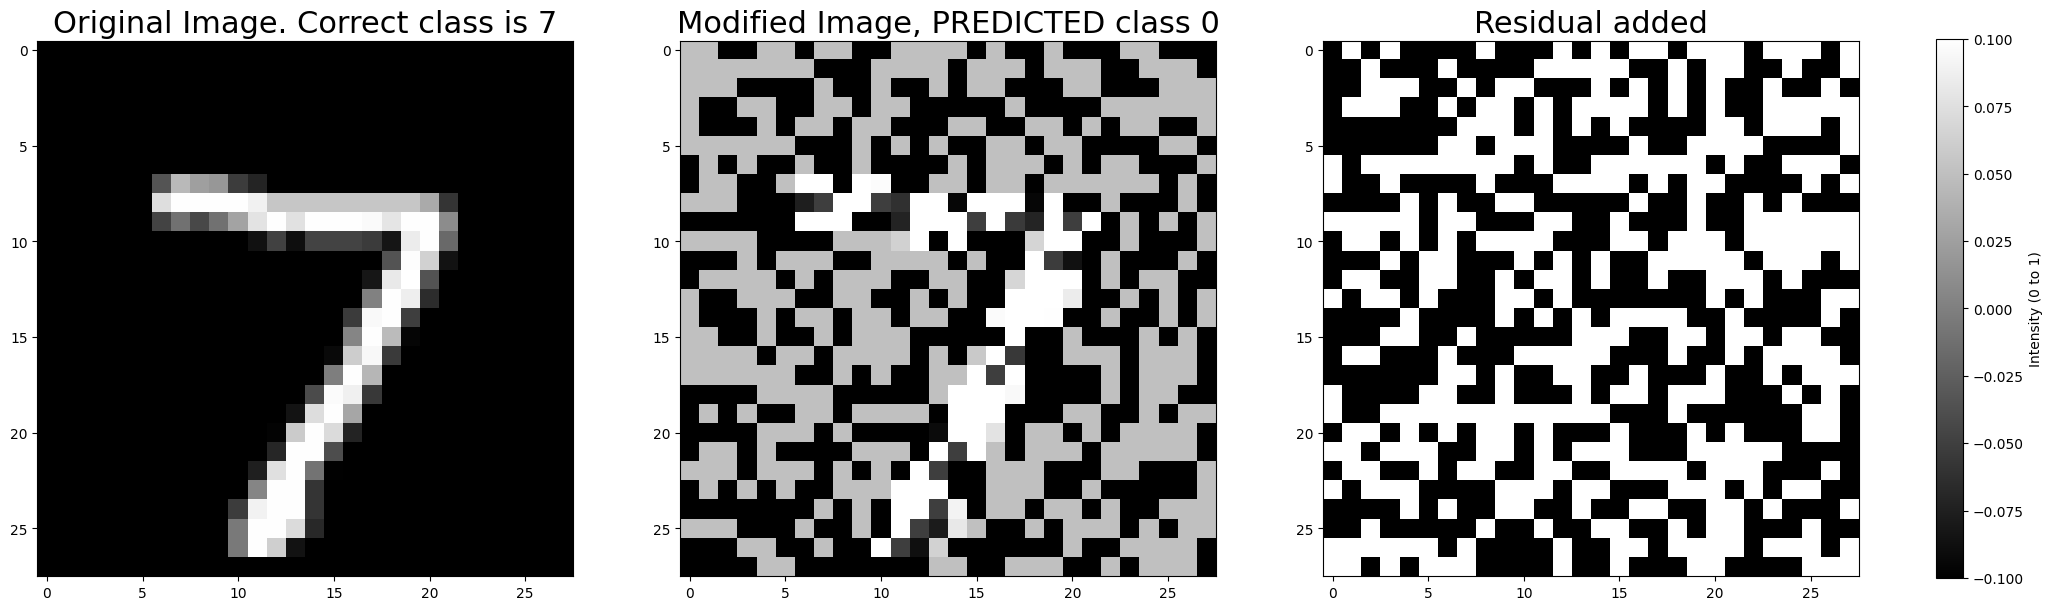

Using epsilon: 0.9 we successfully create 100.00% adversarial examples


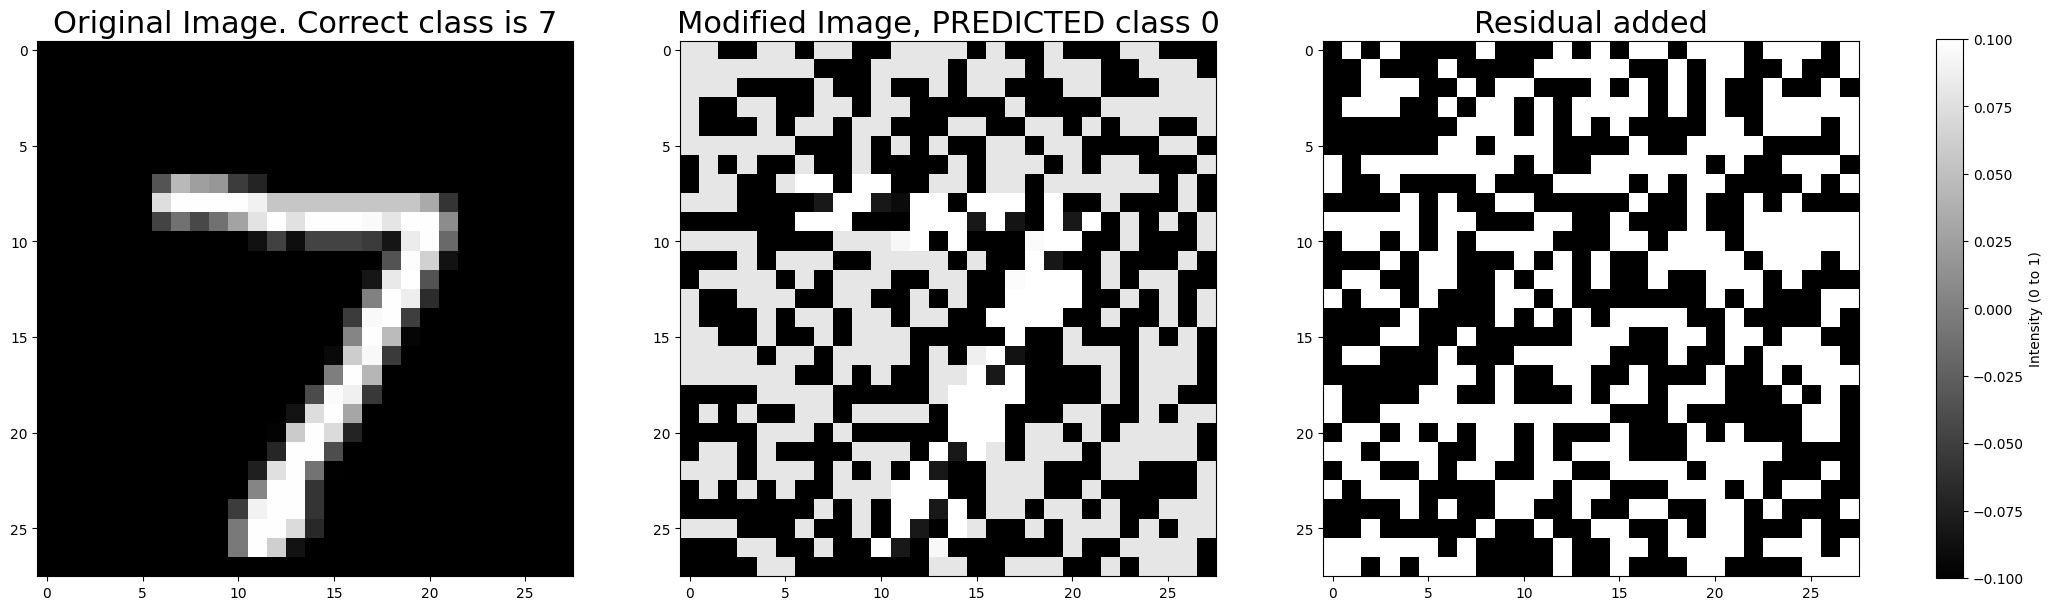

Using epsilon: 0.99 we successfully create 100.00% adversarial examples


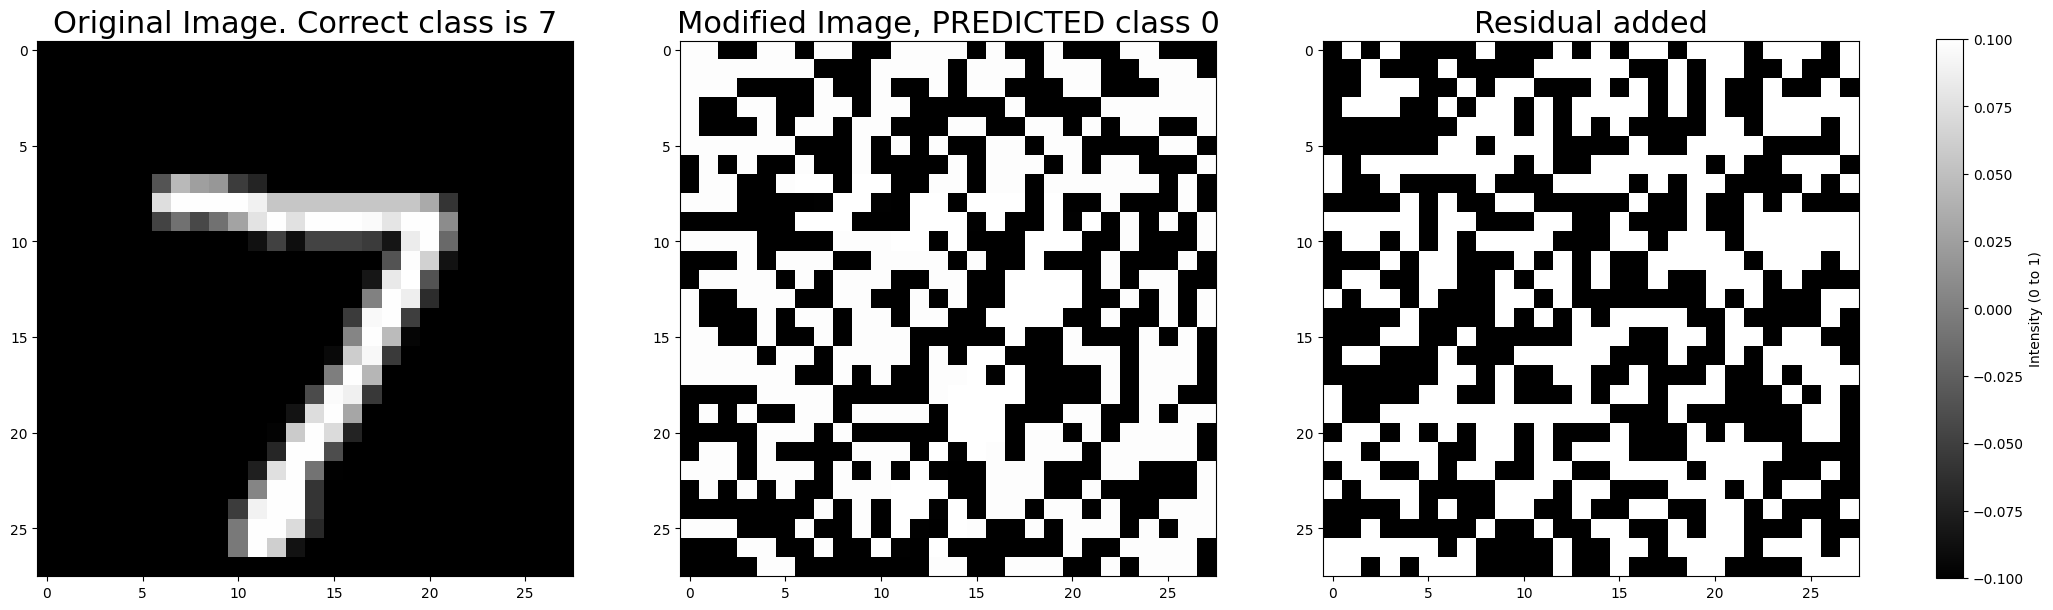

The best epsilon value is 0.1 with a success rate of 100.00%.


In [17]:
def fgsm_attack(X, Y, model, loss_model, eps):

    X = X.unsqueeze(0).to(device)
    X.requires_grad = True

    pred_original = model(X)
    original_class=torch.tensor([Y], device=X.device)

    # Compute loss
    cost = loss_model(pred_original, original_class)

    # Zero existing (previous) gradients
    model.zero_grad()

    # Compute gradients
    cost.backward()

    # FGSM attack code
    Xr = X + eps*X.grad.data.sign()
    Xr = torch.clamp(Xr,0,1)

    # Re-classify the perturbed image
    pred_perturbed = model(Xr)
    perturbed_class=pred_perturbed.argmax(dim=1)

    return Xr, original_class, perturbed_class, r

# Accuracy counter
eps_values = [0.005, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.9, 0.99]
loss_model = torch.nn.CrossEntropyLoss()
model.eval()
best_eps = None
highest_success_rate = 0

for eps in eps_values:
    adv_examples = []
    success_count = 0
    total_count = 0

    for X_batch, Y_batch in test_loader:
        for X, Y in zip(X_batch, Y_batch):
            Xr, original_class, perturbed_class, r = fgsm_attack(X, Y, model, loss_model, eps)

            if original_class.item() != perturbed_class.item():
                success_count += 1
                adv_examples.append((X, r, Xr, Y, perturbed_class))

            total_count += 1

    success_rate = (success_count / total_count) * 100
    print(f"Using epsilon: {eps} we successfully create {success_rate:.2f}% adversarial examples")

    if success_rate > highest_success_rate:
        highest_success_rate = success_rate
        best_eps = eps

    # Plot one example
    if len(adv_examples) > 0:
        index = 0
        X, r, Xr, Y, perturbed_class = adv_examples[index]
        plot_results(X, r, Xr, Y, perturbed_class, fail=False)

# Print best epsilon
print(f"The best epsilon value is {best_eps} with a success rate of {highest_success_rate:.2f}%.")

The best possible epsilon value is the one with a very high success rate (near to 100%) that is the lowest one. Indeed, the lower the epsilon value, the more imperceptible the changes. Therefore here, changes are imperceptible for epsilon equals to 0.005, and it has a success rate of 88.98%. Switching to 0.05, the success rate is very close to 100%, but changes are perceptible to a naked human eye.